# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input reading

In [3]:
dirName = '../../data_from_scp/'
name = 'odd_run18.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0

In [5]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    offset_diag3 = nnoise    *   nnoise   *  tvals                  * noperators        * 2         * 8
    offset_diag2 = nnoise * tvals                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        start_reading = start_conf+4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))
                            
                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)


                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            #re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                            re,im = struct.unpack("dd",fileContent[start_reading+offset_diag3:start_reading+offset_diag3+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #update start reading
                            start_reading = start_reading+16

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            #update start reading for the disconnected part
            start_reading = start_reading + offset_diag3
            
            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading+offset_diag2:start_reading+offset_diag2+16])
                    z_corr[ic][t][inoise] = complex(re,im)

                    #update start reading
                    start_reading = start_reading+16
            #update start reading for the 2point with source in z
            start_reading = start_reading + offset_diag2

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152140
Reading: Gauge Conf = 2

2319504
Reading: Gauge Conf = 3

3486868
Reading: Gauge Conf = 4

4654232
Reading: Gauge Conf = 5

5821596
Reading: Gauge Conf = 6

6988960
Reading: Gauge Conf = 7

8156324
Reading: Gauge Conf = 8

9323688
Reading: Gauge Conf = 9

10491052
Reading: Gauge Conf = 10

11658416
Reading: Gauge Conf = 11

12825780
Reading: Gauge Conf = 12

13993144
Reading: Gauge Conf = 13

15160508
Reading: Gauge Conf = 14

16327872
Reading: Gauge Conf = 15

17495236
Reading: Gauge Conf = 16

18662600
Reading: Gauge Conf = 17

19829964
Reading: Gauge Conf = 18

20997328
Reading: Gauge Conf = 19

22164692
Reading: Gauge Conf = 20

23332056
Reading: Gauge Conf = 21

24499420
Reading: Gauge Conf = 22

25666784
Reading: Gauge Conf = 23

26834148
Reading: Gauge Conf = 24

28001512
Reading: Gauge Conf = 25

29168876
Reading: Gauge Conf = 26

30336240
Reading: Gauge Conf = 27

31503604
Reading: Gauge Conf = 28

32670968
Reading: Gauge Conf = 29

33838332
Re

In [6]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [7]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(991, 2, 1, 5, 32, 15, 15)


In [8]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(991, 1, 32, 15)
(991, 1, 32, 15)


# Jackknife with matrix element as estimate

## noise average

In [9]:
corr_3p = all_correlators[:,0,0,:,:,:,:] + all_correlators[:,1,0,:,:,:,:]
corr_3p_navg = corr_3p.mean(axis=-1).mean(axis=-1)

corr_x = all_2point_x[:,0,:,:]
corr_x_navg = corr_x.mean(axis=-1)

corr_z = all_2point_z[:,0,:,:]
corr_z_navg = corr_z.mean(axis=-1)


if verbose:
    print("(nconf,tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))
    print("(nconf,noperators,tvals)")
    print(np.shape(corr_3p_navg))

(nconf,tvals)
(991, 32)
(991, 32)
(nconf,noperators,tvals)
(991, 5, 32)


## creation of jackknife resampling

In [10]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_3p_navg_resamp = np.asarray( [np.delete(corr_3p_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )
corr_x_navg_resamp = np.asarray( [np.delete(corr_x_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )
corr_z_navg_resamp = np.asarray( [np.delete(corr_z_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,tvals)")
    print(np.shape(corr_x_navg_resamp))
    print(np.shape(corr_z_navg_resamp))
    print("(nresamples,nconf-delta,noperators,tvals)")
    print(np.shape(corr_3p_navg_resamp))

(nresamples,nconf-delta,tvals)
(991, 990, 32)
(991, 990, 32)
(nresamples,nconf-delta,noperators,tvals)
(991, 990, 5, 32)


## matrix element average jackknife estimation

In [11]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_3p_navg_resamp_gavg = corr_3p_navg_resamp.mean(axis=1)
corr_x_navg_resamp_gavg = corr_x_navg_resamp.mean(axis=1)
corr_z_navg_resamp_gavg = corr_z_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
matele_array = np.empty(shape=(nresamples,noperators,tvals),dtype=float)


#then we estimate the matrix element
for ires in range(nresamples):
    for iop in range(noperators):
        for t in range(tvals):
            matele_array[ires,iop,t] = np.sqrt( ( corr_3p_navg_resamp_gavg[ires,iop,t] * np.conjugate( corr_3p_navg_resamp_gavg[ires,iop,tvals-1-t] ) / ( corr_z_navg_resamp_gavg[ires,1] * corr_x_navg_resamp_gavg[ires,tvals-2] ) ).real )






#we then estimate the matrix element also on the whole dataset

corr_3p_navg_gavg = corr_3p_navg.mean(axis=0)
corr_x_navg_gavg = corr_x_navg.mean(axis=0)
corr_z_navg_gavg = corr_z_navg.mean(axis=0)

#this is the array with the matrix element computed on the whole dataset !!!
matele_array_jacktotal = np.empty(shape=(noperators,tvals),dtype=float)

for iop in range(noperators):
    for t in range(tvals):
        matele_array_jacktotal[iop,t] = np.sqrt( ( corr_3p_navg_gavg[iop,t] * np.conjugate( corr_3p_navg_gavg[iop,tvals-1-t] ) / ( corr_z_navg_gavg[1] * corr_x_navg_gavg[tvals-2] ) ).real )





if verbose:
    print("(nresamples,tvals)")
    print(np.shape(corr_x_navg_resamp_gavg))
    print(np.shape(corr_x_navg_resamp_gavg))
    print("(nresamples,noperators,tvals)")
    print(np.shape(corr_3p_navg_resamp_gavg))

    print("(tvals)")
    print(np.shape(corr_x_navg_gavg))
    print(np.shape(corr_x_navg_gavg))
    print("(noperators,tvals)")
    print(np.shape(corr_3p_navg_gavg))

(nresamples,tvals)
(991, 32)
(991, 32)
(nresamples,noperators,tvals)
(991, 5, 32)
(tvals)
(32,)
(32,)
(noperators,tvals)
(5, 32)


In [12]:
#the estimate is the mean of the replicates
estimate = np.mean(matele_array,axis=0)

#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
bias = (nresamples-1) * (estimate-matele_array_jacktotal)


#wrong formula for std ???
#std = np.std(matele_array,axis=0) * np.sqrt(nresamples-1) #/ np.sqrt(nresamples) 

#the std is given by the following formula (variance of replicates times n-1)
std = np.sqrt( (nresamples-1)/nresamples * np.sum( (matele_array - estimate)**2,axis=0 ) )

#then we correct the estimate for the bias
estimate_biascorr = estimate-bias

if verbose:
    print("(noperators,tvals)")
    print(np.shape(estimate_biascorr))
    print(np.shape(std))

(noperators,tvals)
(5, 32)
(5, 32)


In [13]:
estimate_biascorr

std

array([[0.00000000e+00, 8.66501004e-08, 3.95349324e-08, 2.84444761e-08,
        2.33885777e-08, 2.13045869e-08, 2.04198346e-08, 2.00516455e-08,
        1.99377662e-08, 1.99177422e-08, 1.99186742e-08, 1.99327793e-08,
        2.00030453e-08, 2.00742754e-08, 2.00506418e-08, 2.00352346e-08,
        2.00352345e-08, 2.00506419e-08, 2.00742753e-08, 2.00030453e-08,
        1.99327790e-08, 1.99186738e-08, 1.99177415e-08, 1.99377657e-08,
        2.00516447e-08, 2.04198336e-08, 2.13045854e-08, 2.33885744e-08,
        2.84444682e-08, 3.95349084e-08, 8.66500206e-08, 0.00000000e+00],
       [0.00000000e+00, 9.16944428e-08, 2.02753772e-08, 1.94874624e-08,
        1.65338223e-08, 1.51399359e-08, 1.45332735e-08, 1.42348283e-08,
        1.41793283e-08, 1.41795597e-08, 1.41400352e-08, 1.41159503e-08,
        1.41965953e-08, 1.42819777e-08, 1.43051090e-08, 1.43252147e-08,
        1.43252145e-08, 1.43051089e-08, 1.42819774e-08, 1.41965948e-08,
        1.41159501e-08, 1.41400349e-08, 1.41795590e-08, 1.41793

array([[0.00000000e+00, 1.40317420e-09, 6.24682133e-10, 4.43790762e-10,
        3.57115951e-10, 3.16319140e-10, 2.94314168e-10, 2.78294582e-10,
        2.68212965e-10, 2.59273134e-10, 2.51450597e-10, 2.47772542e-10,
        2.48368857e-10, 2.49645459e-10, 2.49843924e-10, 2.56048324e-10,
        2.56048323e-10, 2.49843941e-10, 2.49645477e-10, 2.48368866e-10,
        2.47772587e-10, 2.51450679e-10, 2.59273316e-10, 2.68213137e-10,
        2.78294849e-10, 2.94314518e-10, 3.16319548e-10, 3.57116468e-10,
        4.43791260e-10, 6.24682568e-10, 1.40317166e-09, 0.00000000e+00],
       [0.00000000e+00, 1.46099675e-09, 3.33200692e-10, 2.96050342e-10,
        2.40612792e-10, 2.12849035e-10, 1.95562933e-10, 1.83709974e-10,
        1.76805985e-10, 1.71769227e-10, 1.67535120e-10, 1.62905044e-10,
        1.64775052e-10, 1.70031246e-10, 1.78178790e-10, 1.88300795e-10,
        1.88300764e-10, 1.78178763e-10, 1.70031187e-10, 1.64774970e-10,
        1.62905048e-10, 1.67535171e-10, 1.71769276e-10, 1.76806

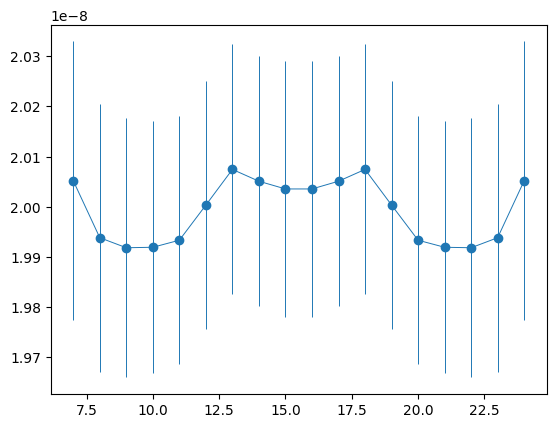

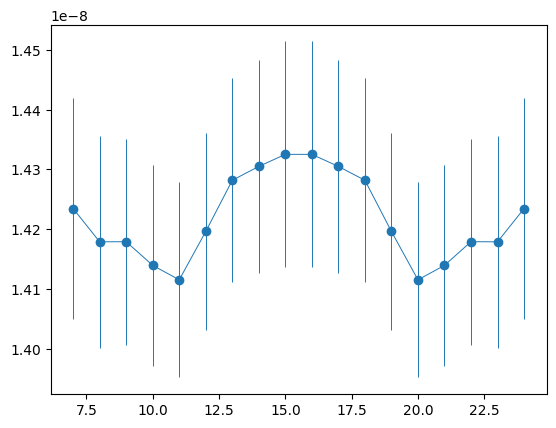

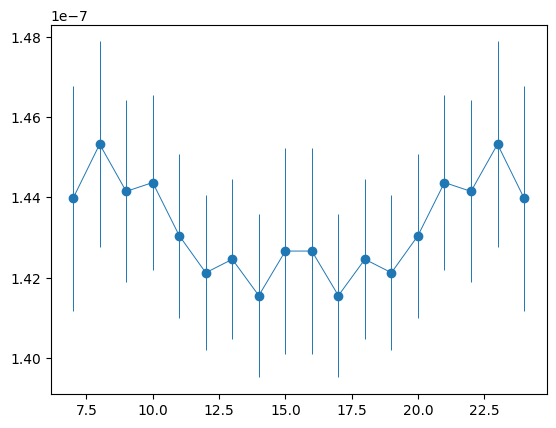

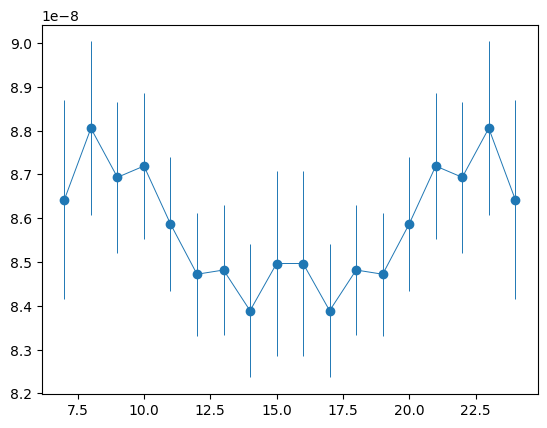

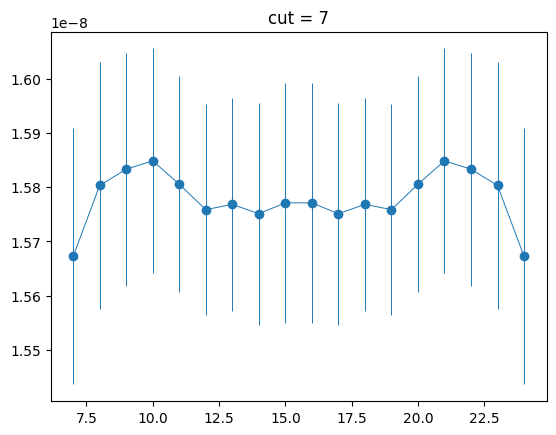

In [14]:
times = np.arange(tvals)
cut = 7

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],estimate_biascorr[iop,cut:-cut],yerr=std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

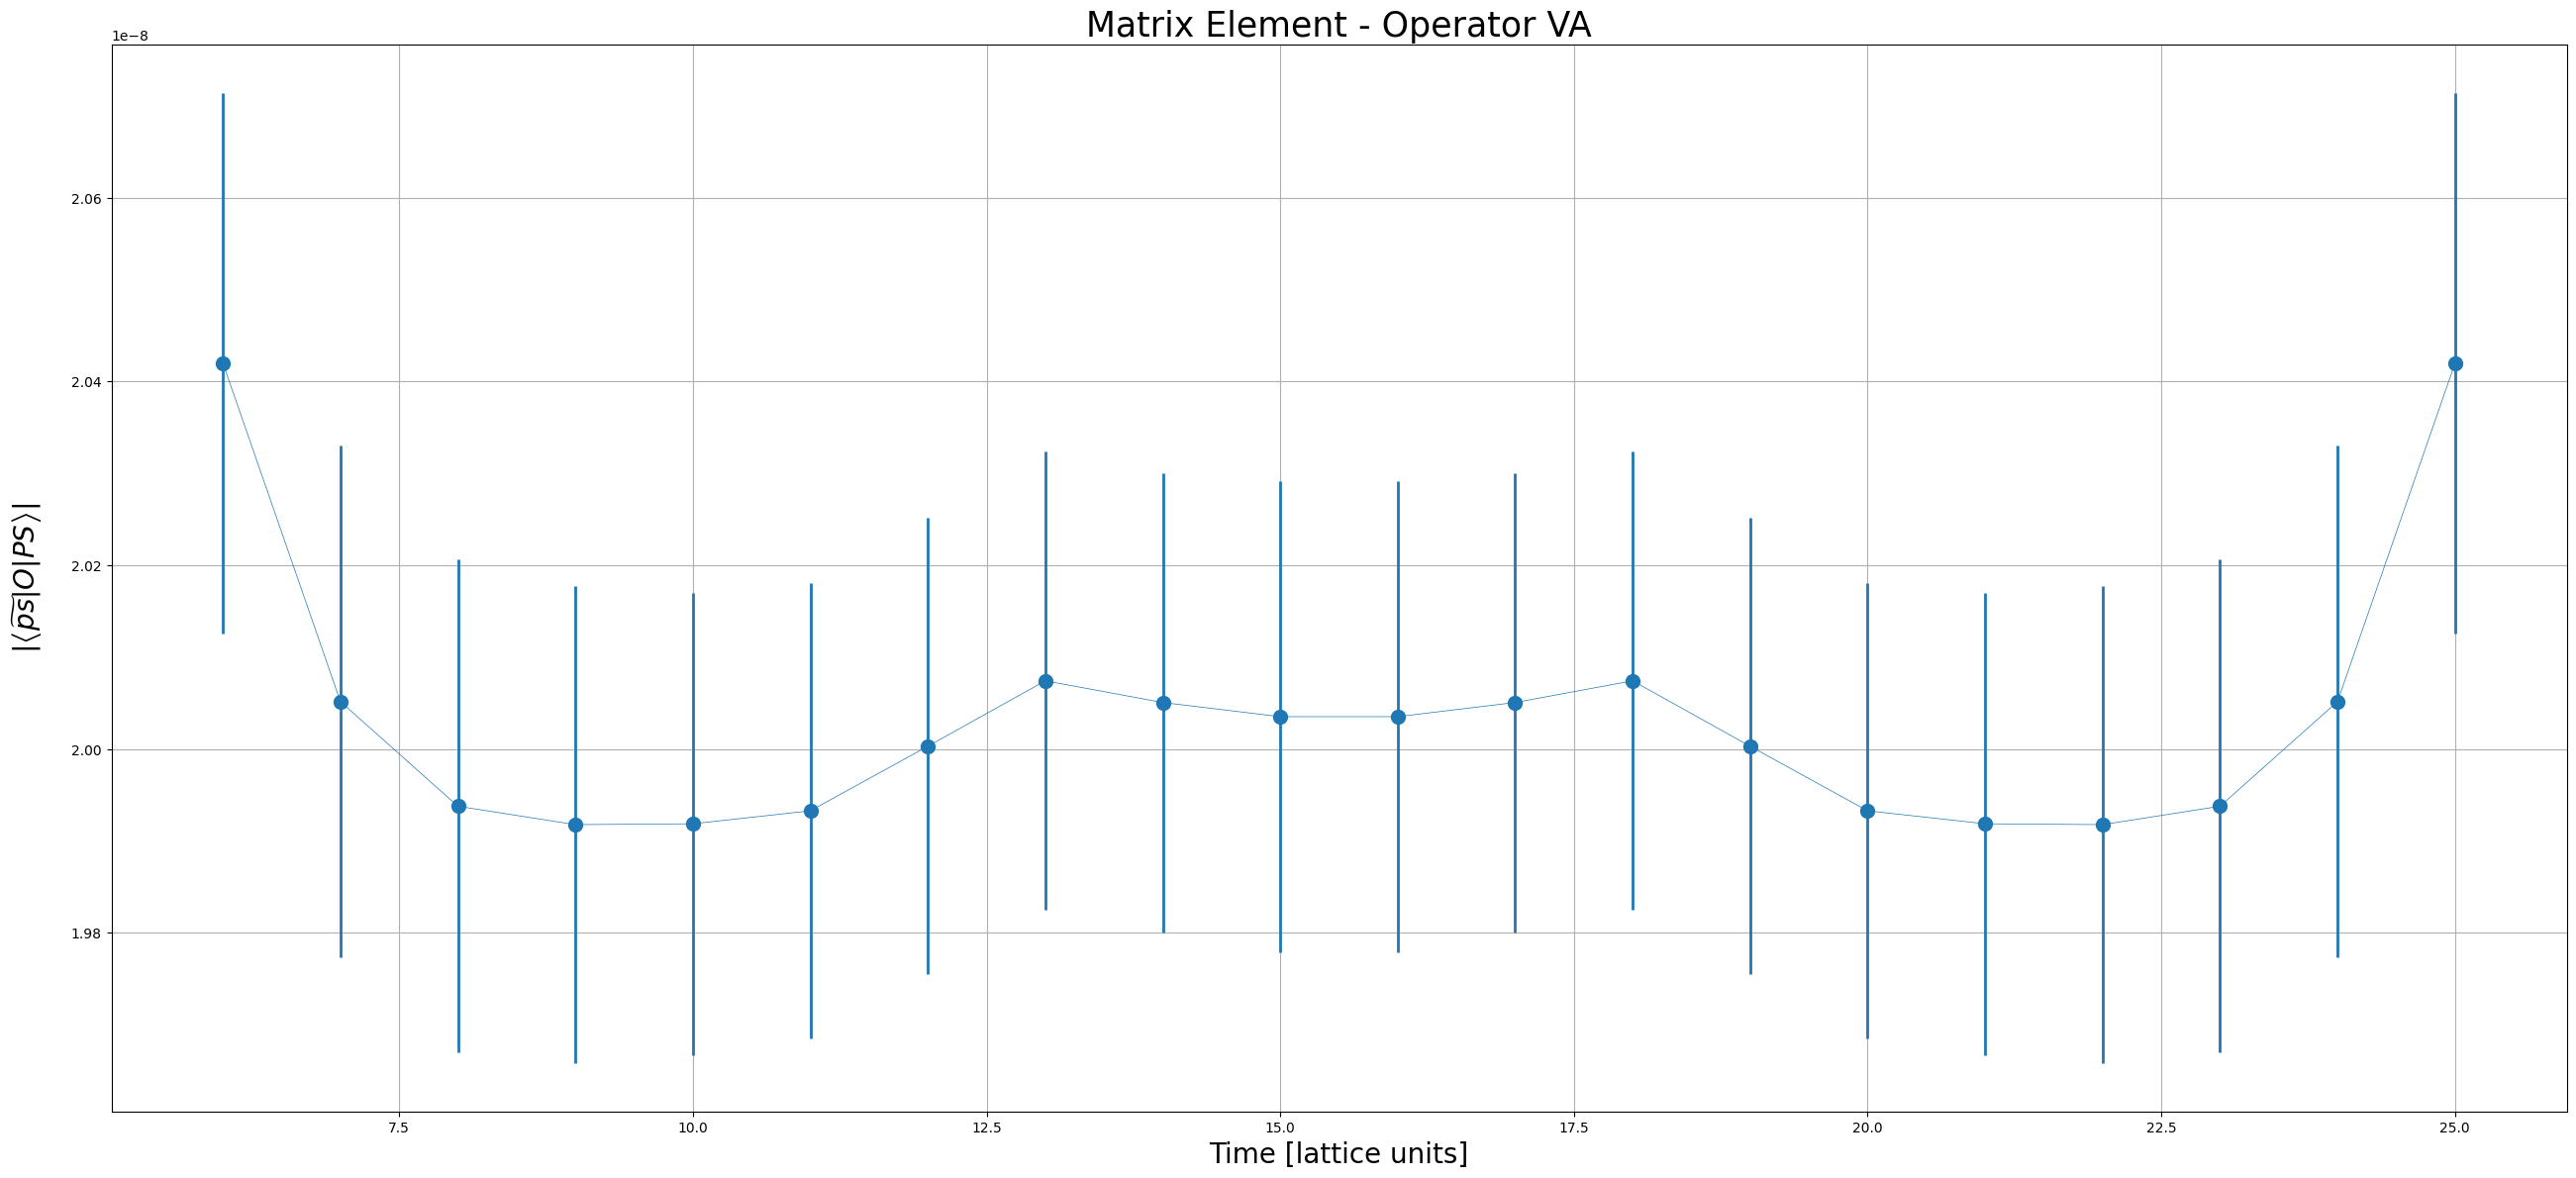

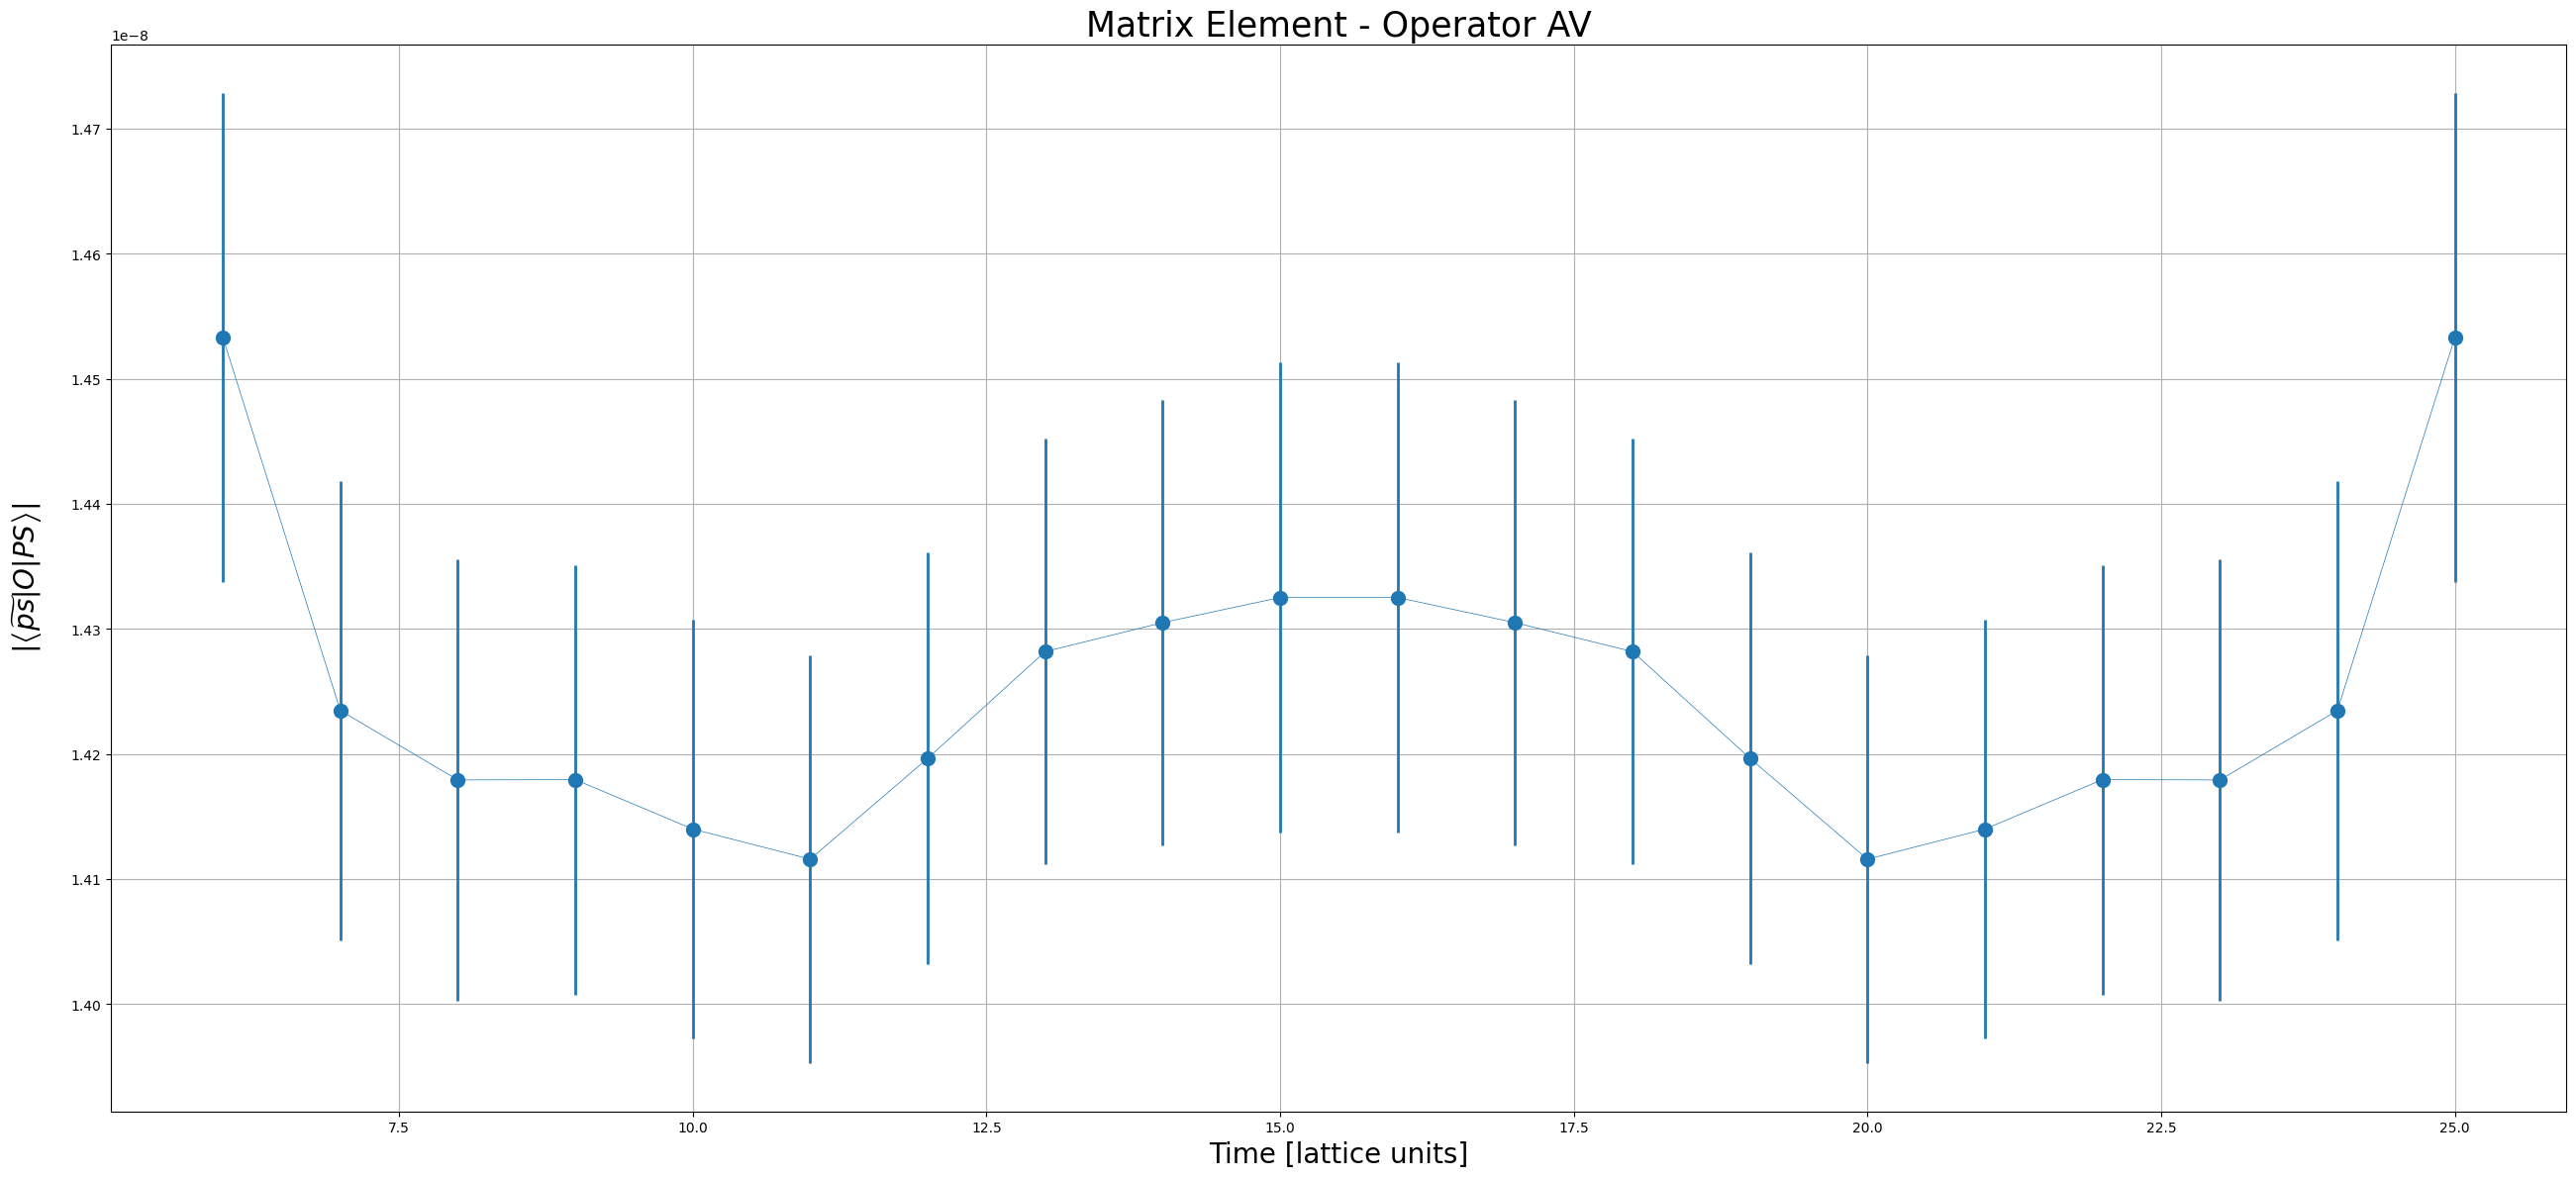

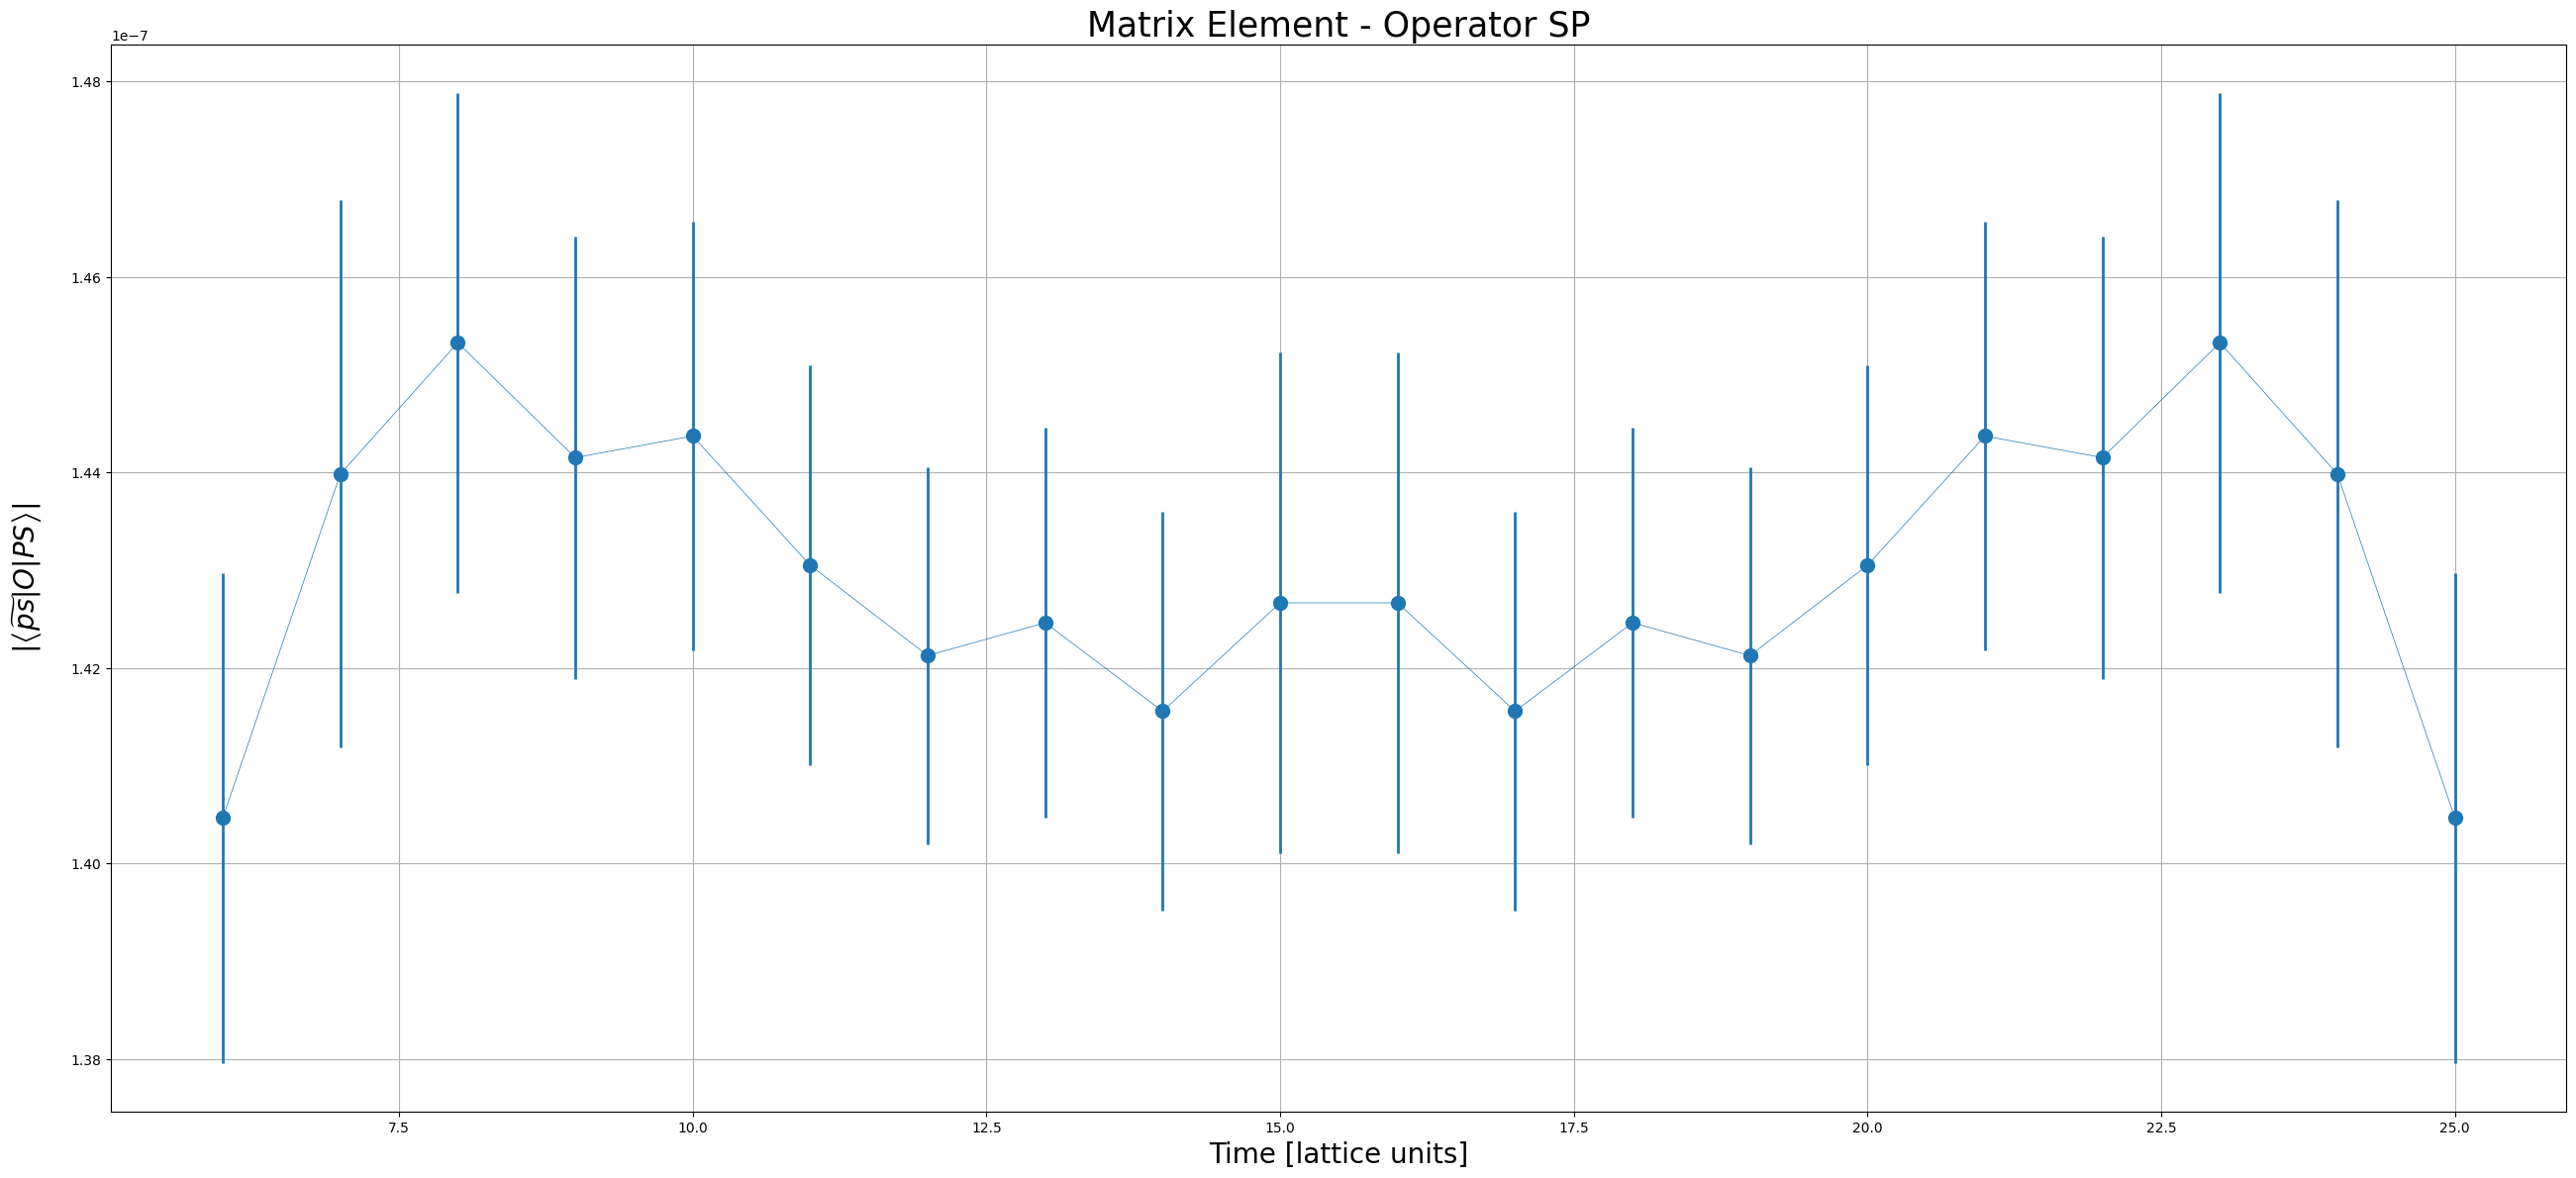

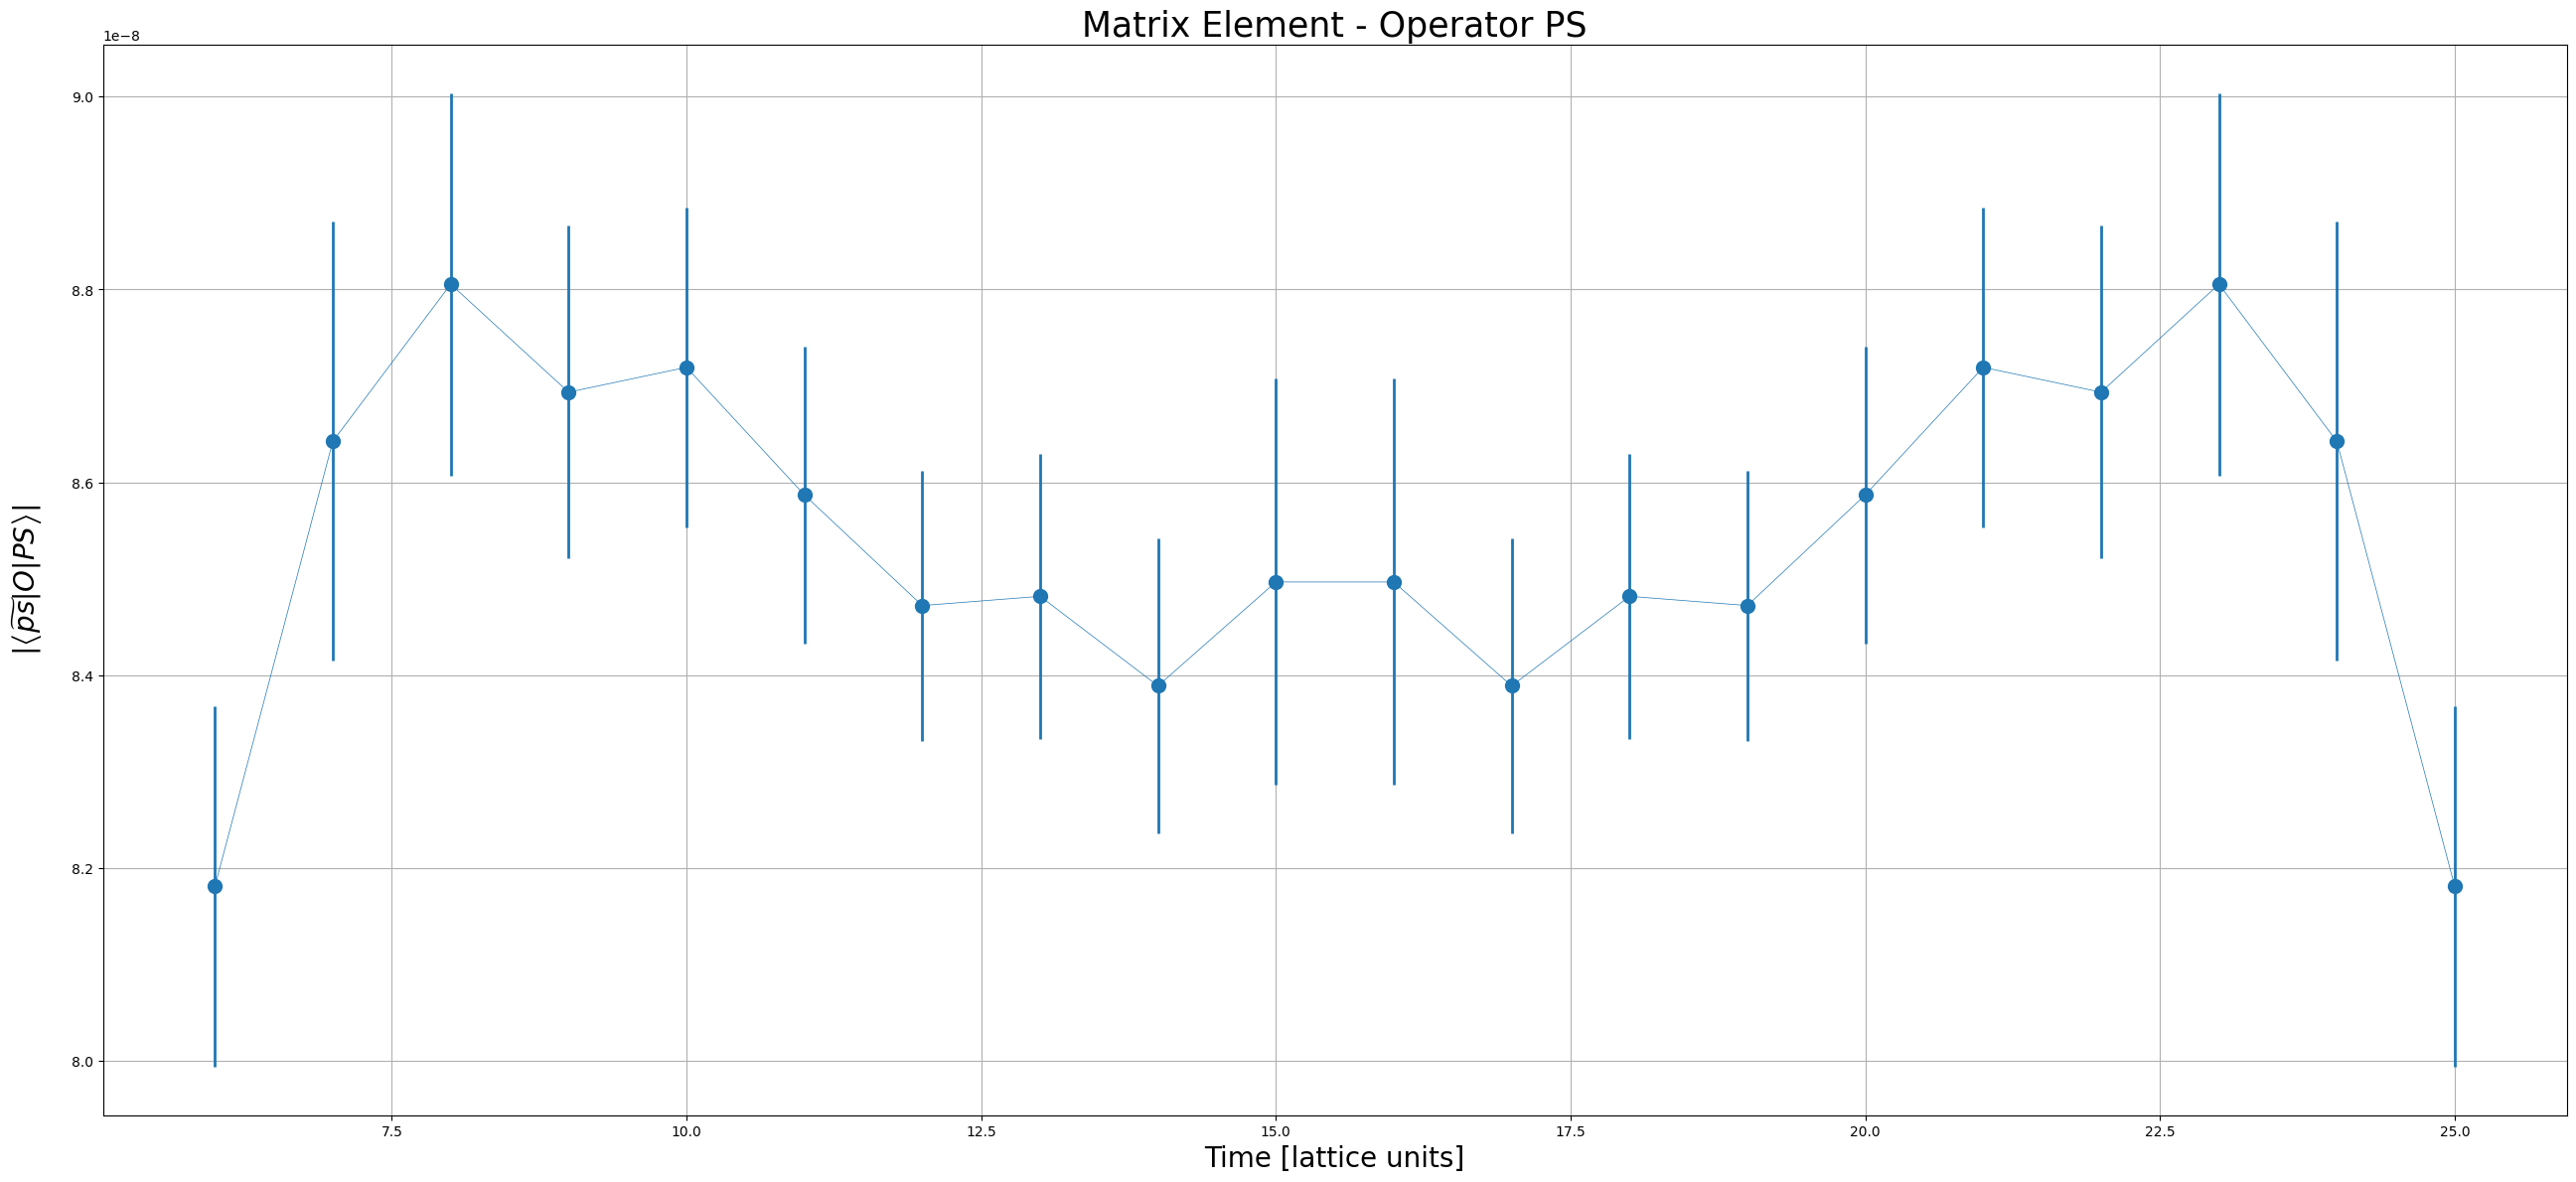

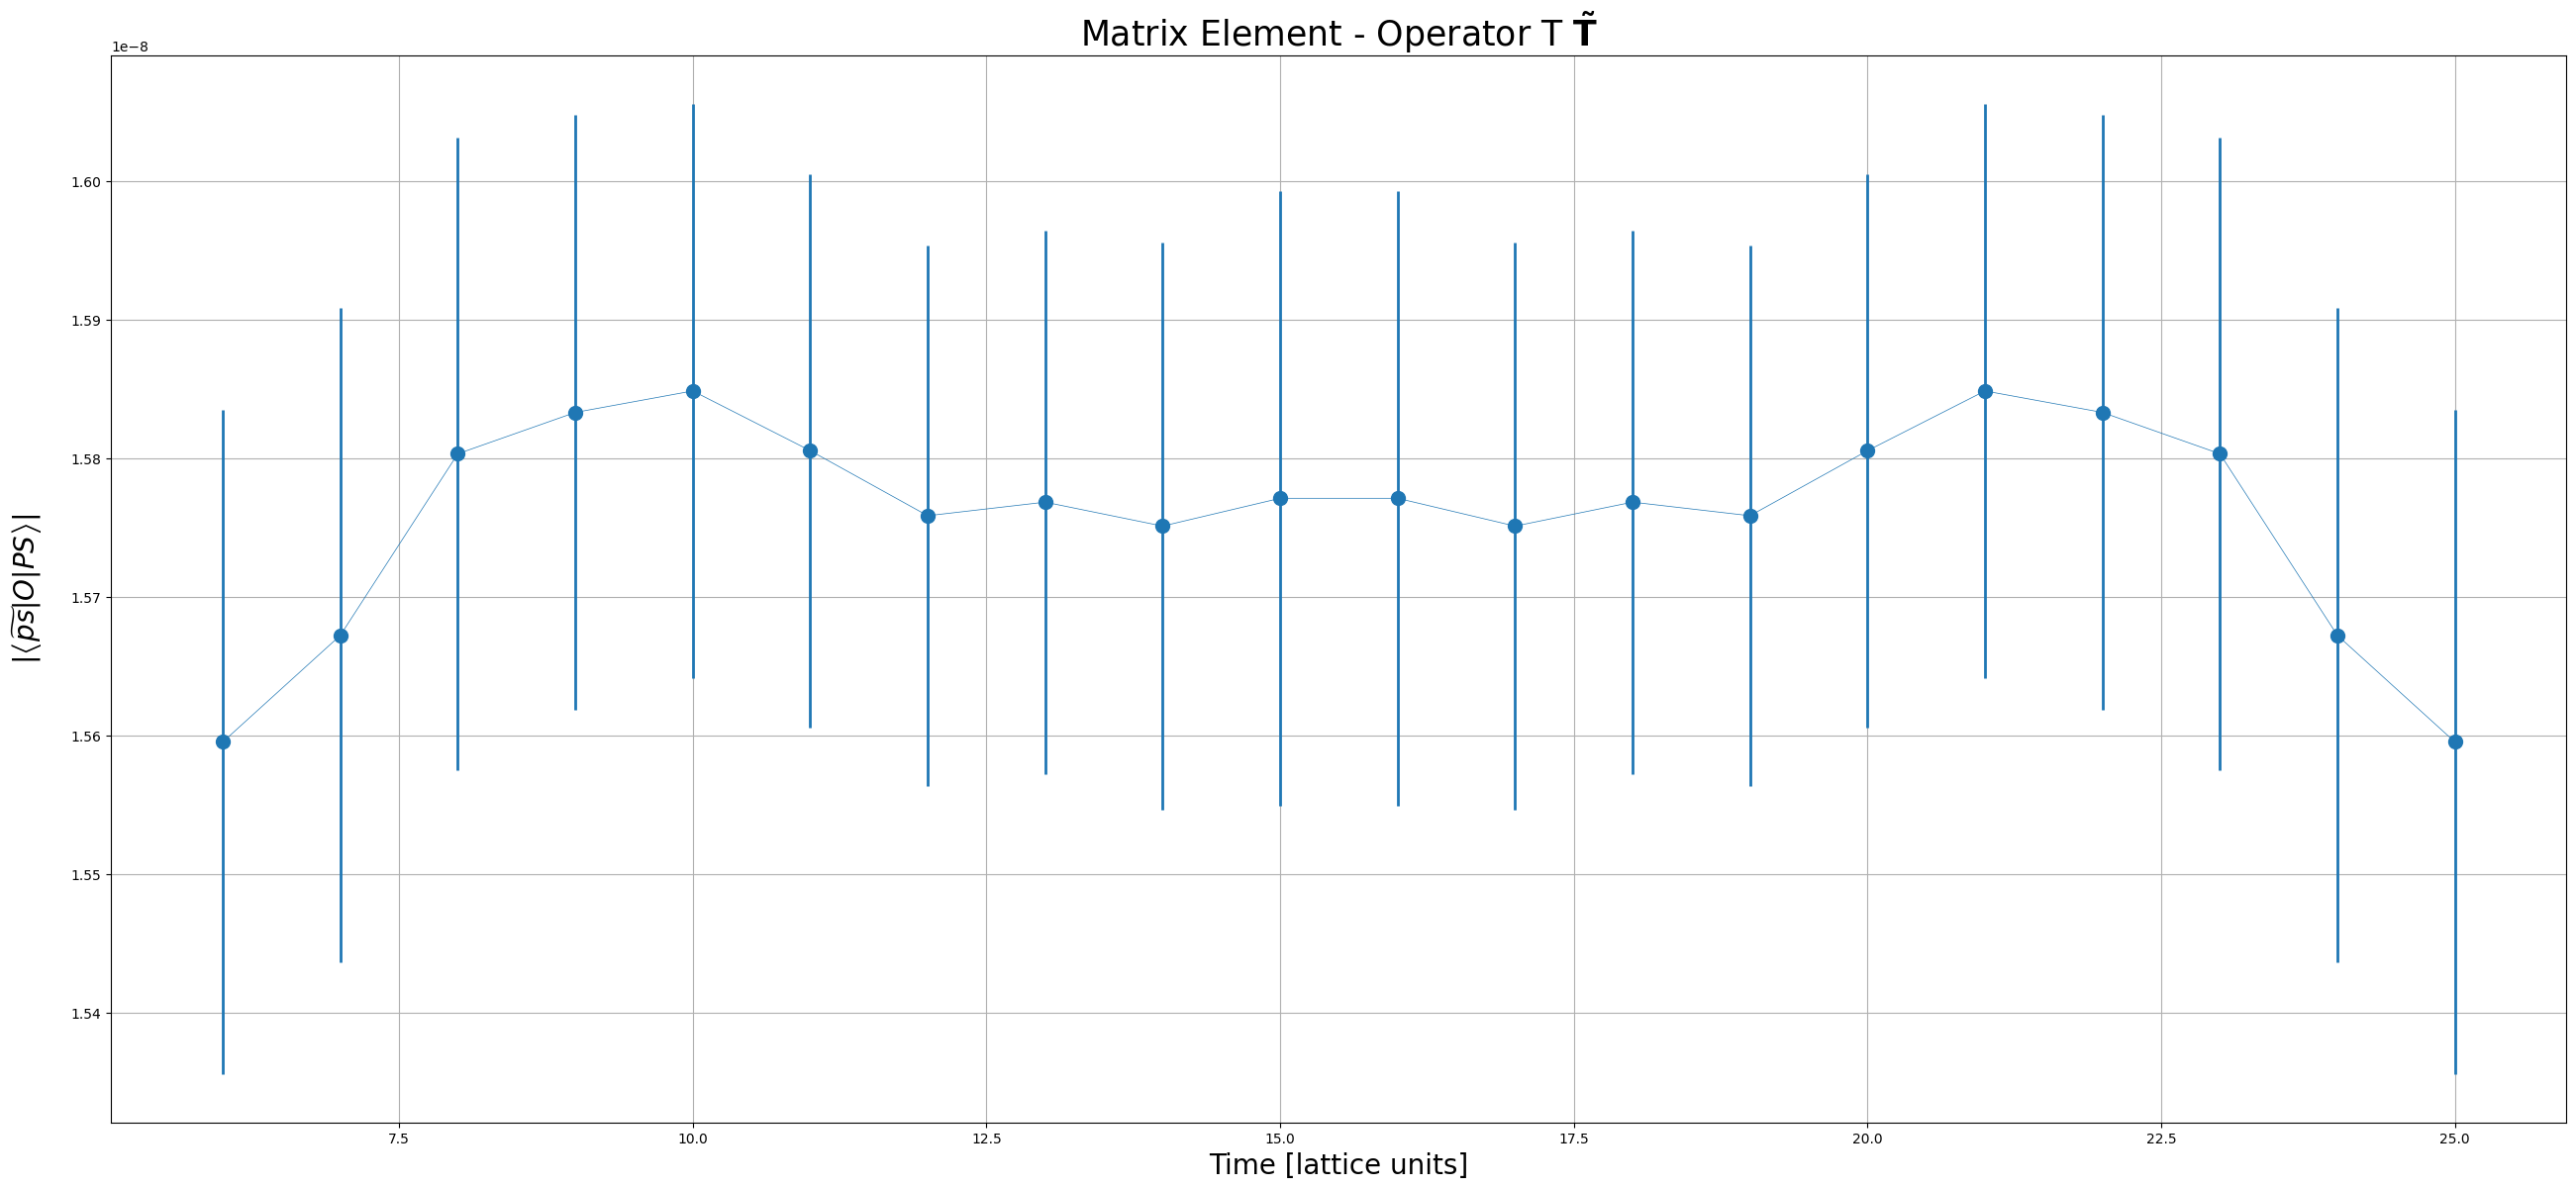

In [15]:
#times on x axis
times = np.arange(0,tvals)

cut=6

op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']
op_names_txt = ["VA","AV","SP","PS",'TTtilda']

#create figure and axis

for iop in range(noperators):
    _= plt.figure(figsize=(32, 14))
    _=plt.errorbar(times[cut:-cut],estimate_biascorr[iop,cut:-cut],yerr=std[iop,cut:-cut],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    plt.grid()
    _=plt.title(f"Matrix Element - Operator {op_names[iop]}",fontsize=25)
    _=plt.ylabel(r'$\left|\left<\widetilde{ps}|O|PS\right>\right|$',rotation=90,labelpad=20,fontsize=20)
    _=plt.xlabel('Time [lattice units]',fontsize=20)
    plt.savefig(f'matrix_element_second_analysis/matrix_element_{op_names_txt[iop]}.png')
    #plt.close()

In [16]:
cut = 7


mat_ele_final = [np.mean(estimate_biascorr[iop,cut:-cut]) for iop in range(noperators) ]
mat_ele_final_std = [np.sqrt( np.mean( std[iop,cut:-cut]**2 ) ) for iop in range(noperators) ]

for iop,ele in enumerate(mat_ele_final):
    print(f"{round(ele,11)} +- {round(mat_ele_final_std[iop],11)}\n")

1.999e-08 +- 2.6e-10

1.422e-08 +- 1.7e-10

1.433e-07 +- 2.28e-09

8.587e-08 +- 1.77e-09

1.578e-08 +- 2.1e-10



# Plateau Determination

In [25]:
def chi2(array,std_array,axis):
    avg = np.mean(array,axis=axis,keepdims=True)
    return np.sum( ((array-avg)/std_array)**2 , axis=axis)

In [29]:
for icut in range(1,int(tvals/2)):
    if (chi2(estimate_biascorr[:,icut:-icut],std[:,icut:-icut],axis=1) < np.shape(estimate_biascorr[:,icut:-icut])[1]).all():
        chosen_cut = icut
        print(f"plateau region for cut = {cut}")
        break

cut = chosen_cut


mat_ele_final = [np.mean(estimate_biascorr[iop,cut:-cut]) for iop in range(noperators) ]
mat_ele_final_std = [np.sqrt( np.mean( std[iop,cut:-cut]**2 ) ) for iop in range(noperators) ]

for iop,ele in enumerate(mat_ele_final):
    print(f"{round(ele,11)} +- {round(mat_ele_final_std[iop],11)}\n")

plateau region for cut = 4
2.003e-08 +- 2.6e-10

1.425e-08 +- 1.8e-10

1.4302e-07 +- 2.31e-09

8.547e-08 +- 1.78e-09

1.576e-08 +- 2.1e-10



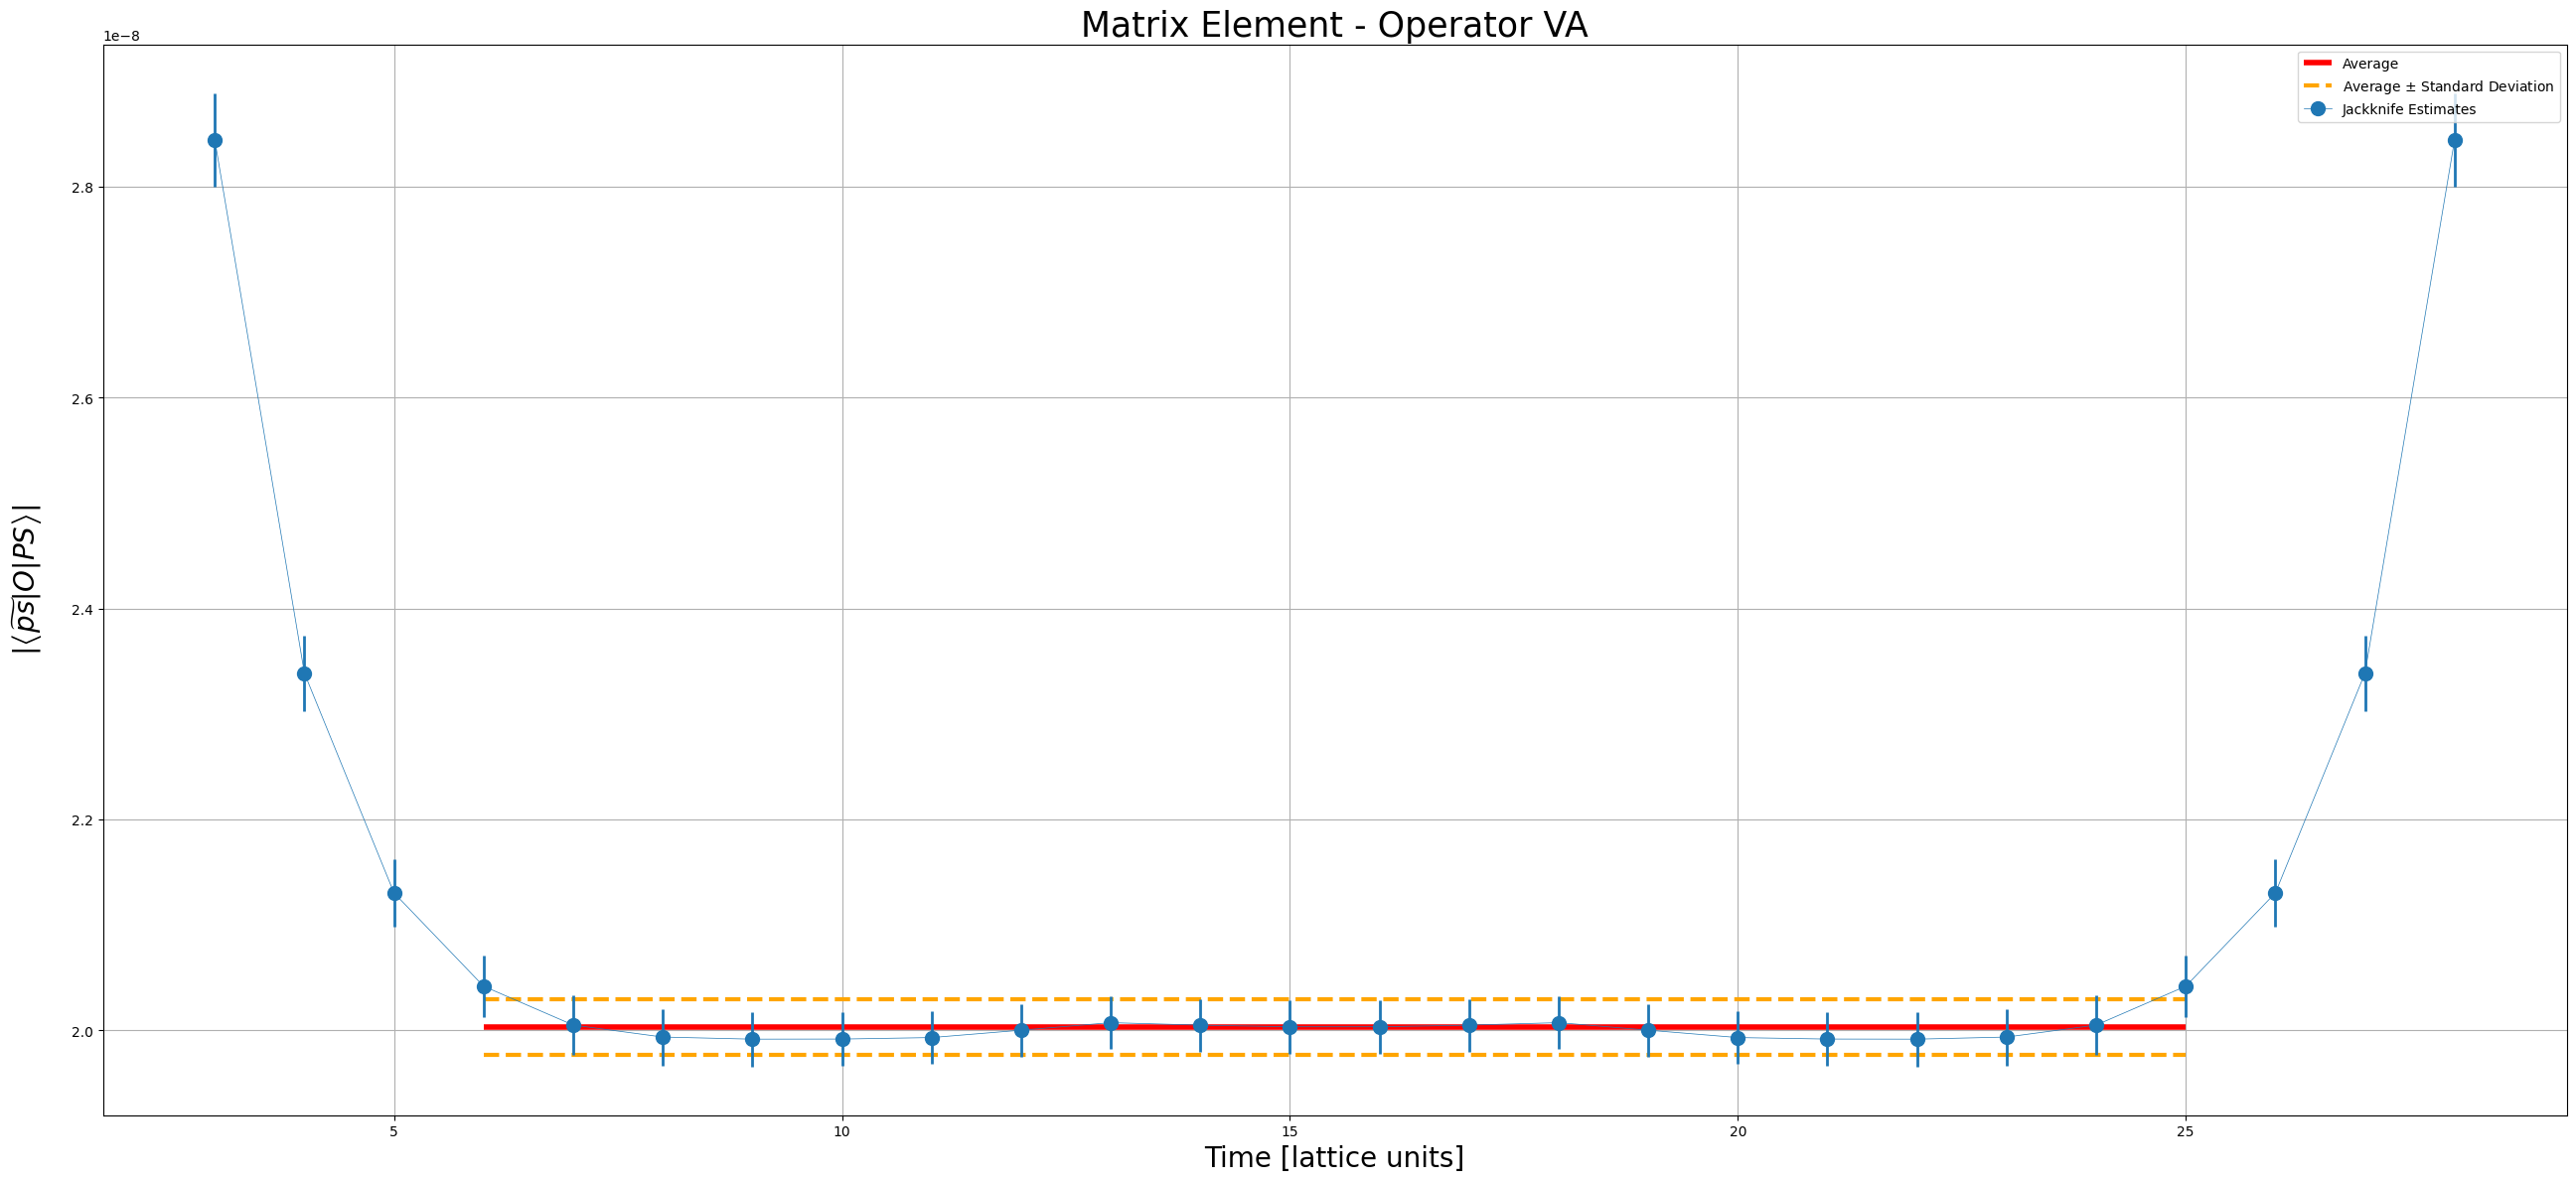

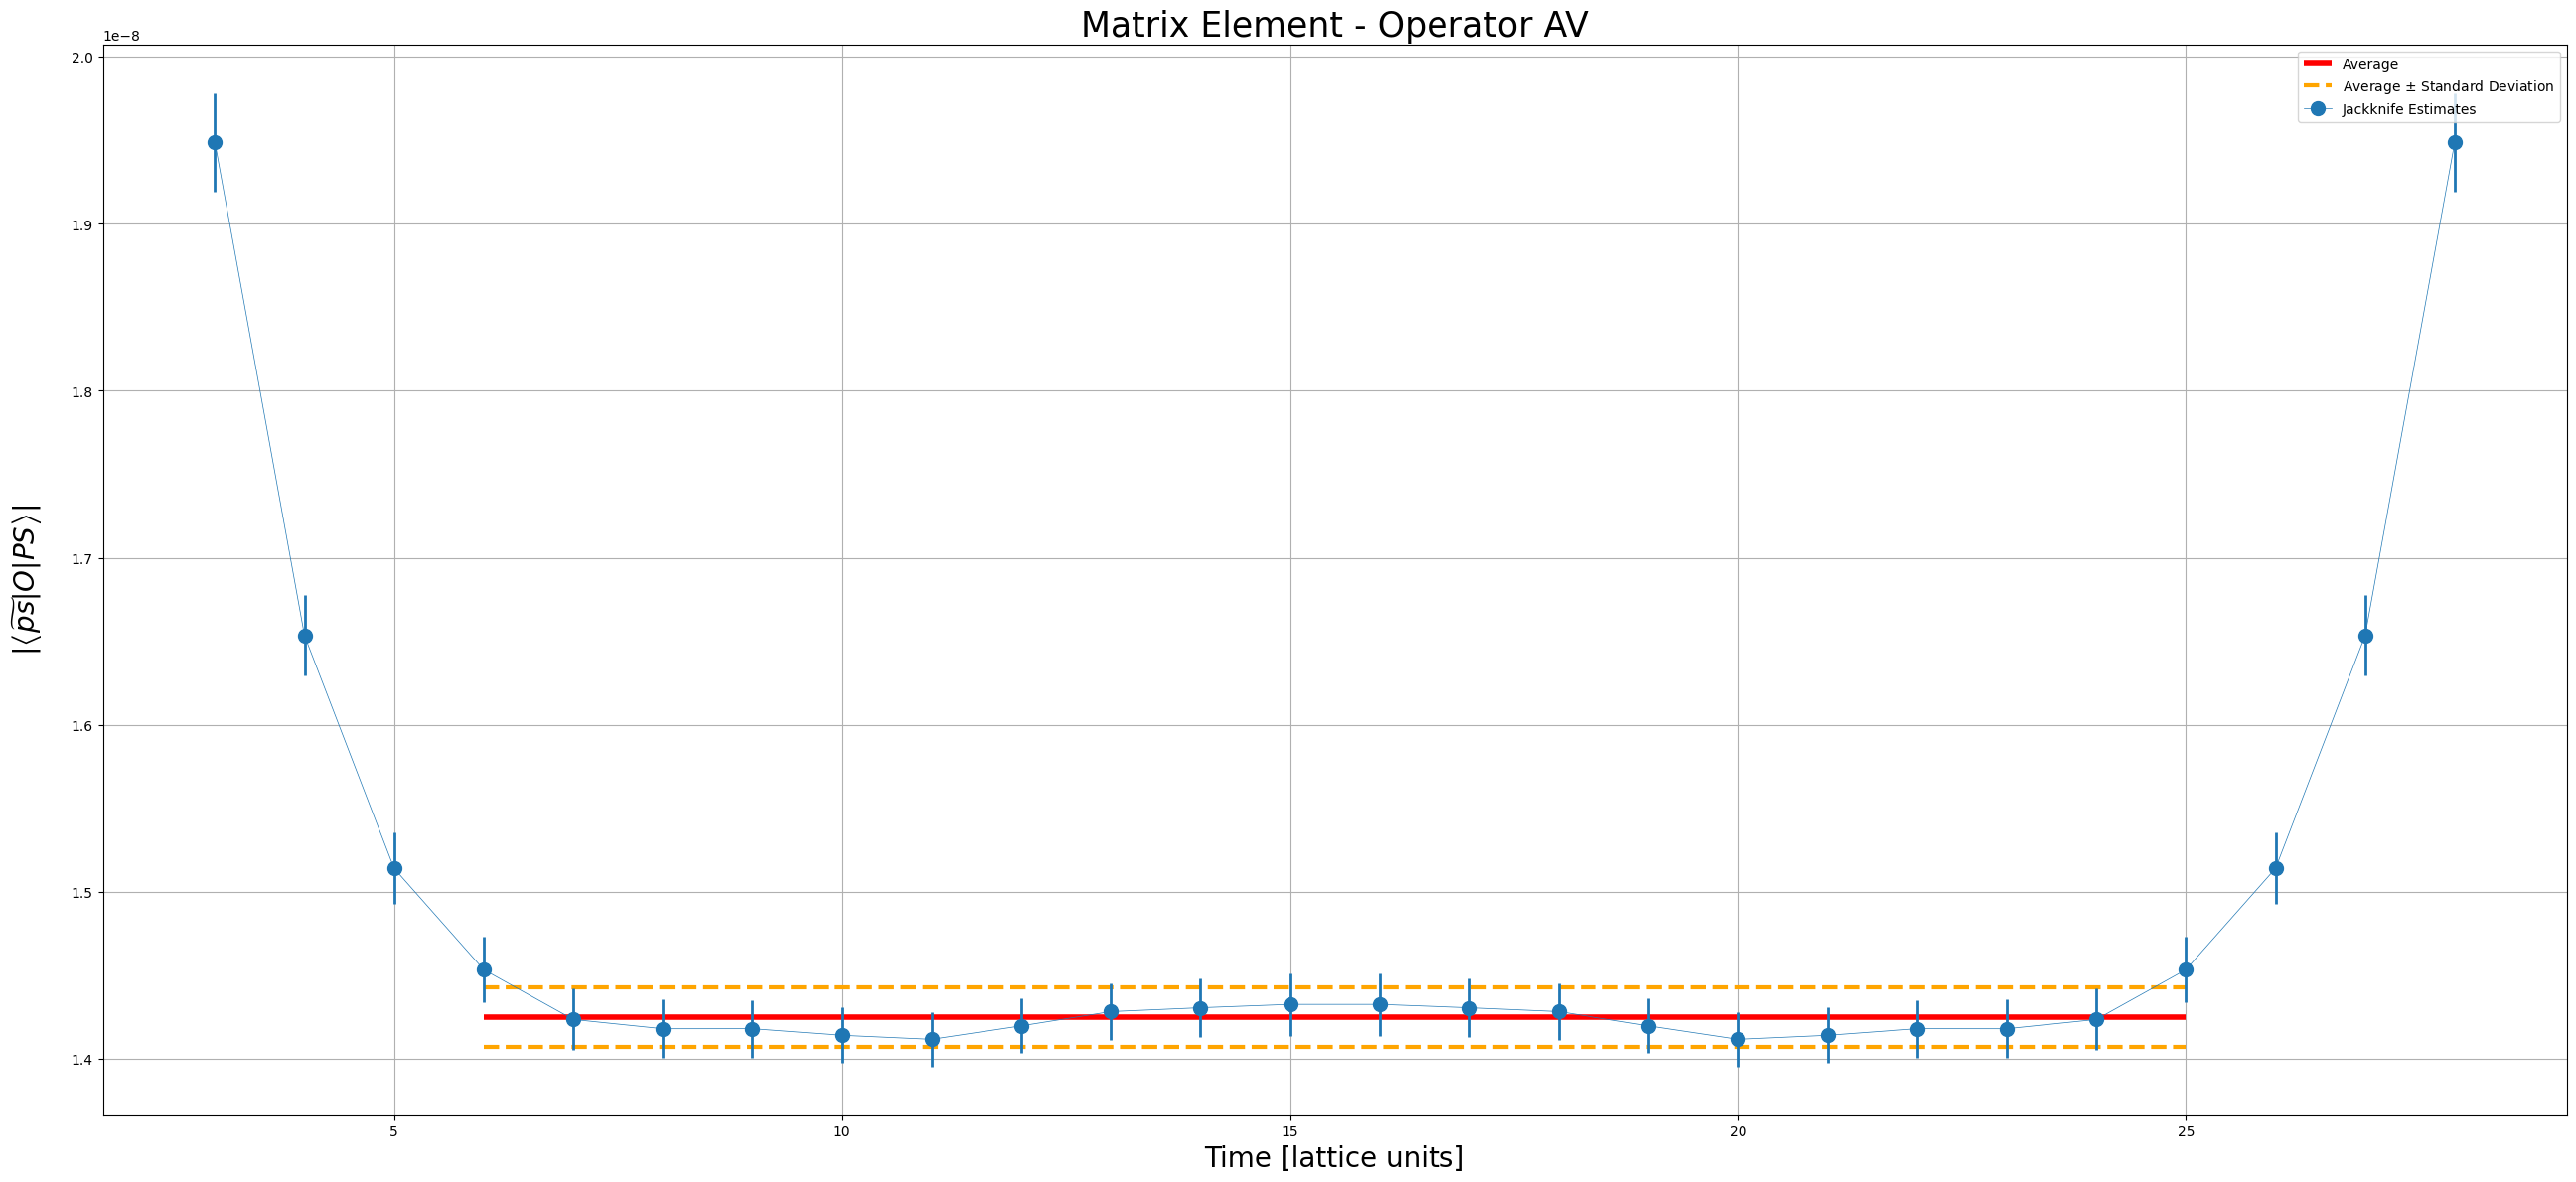

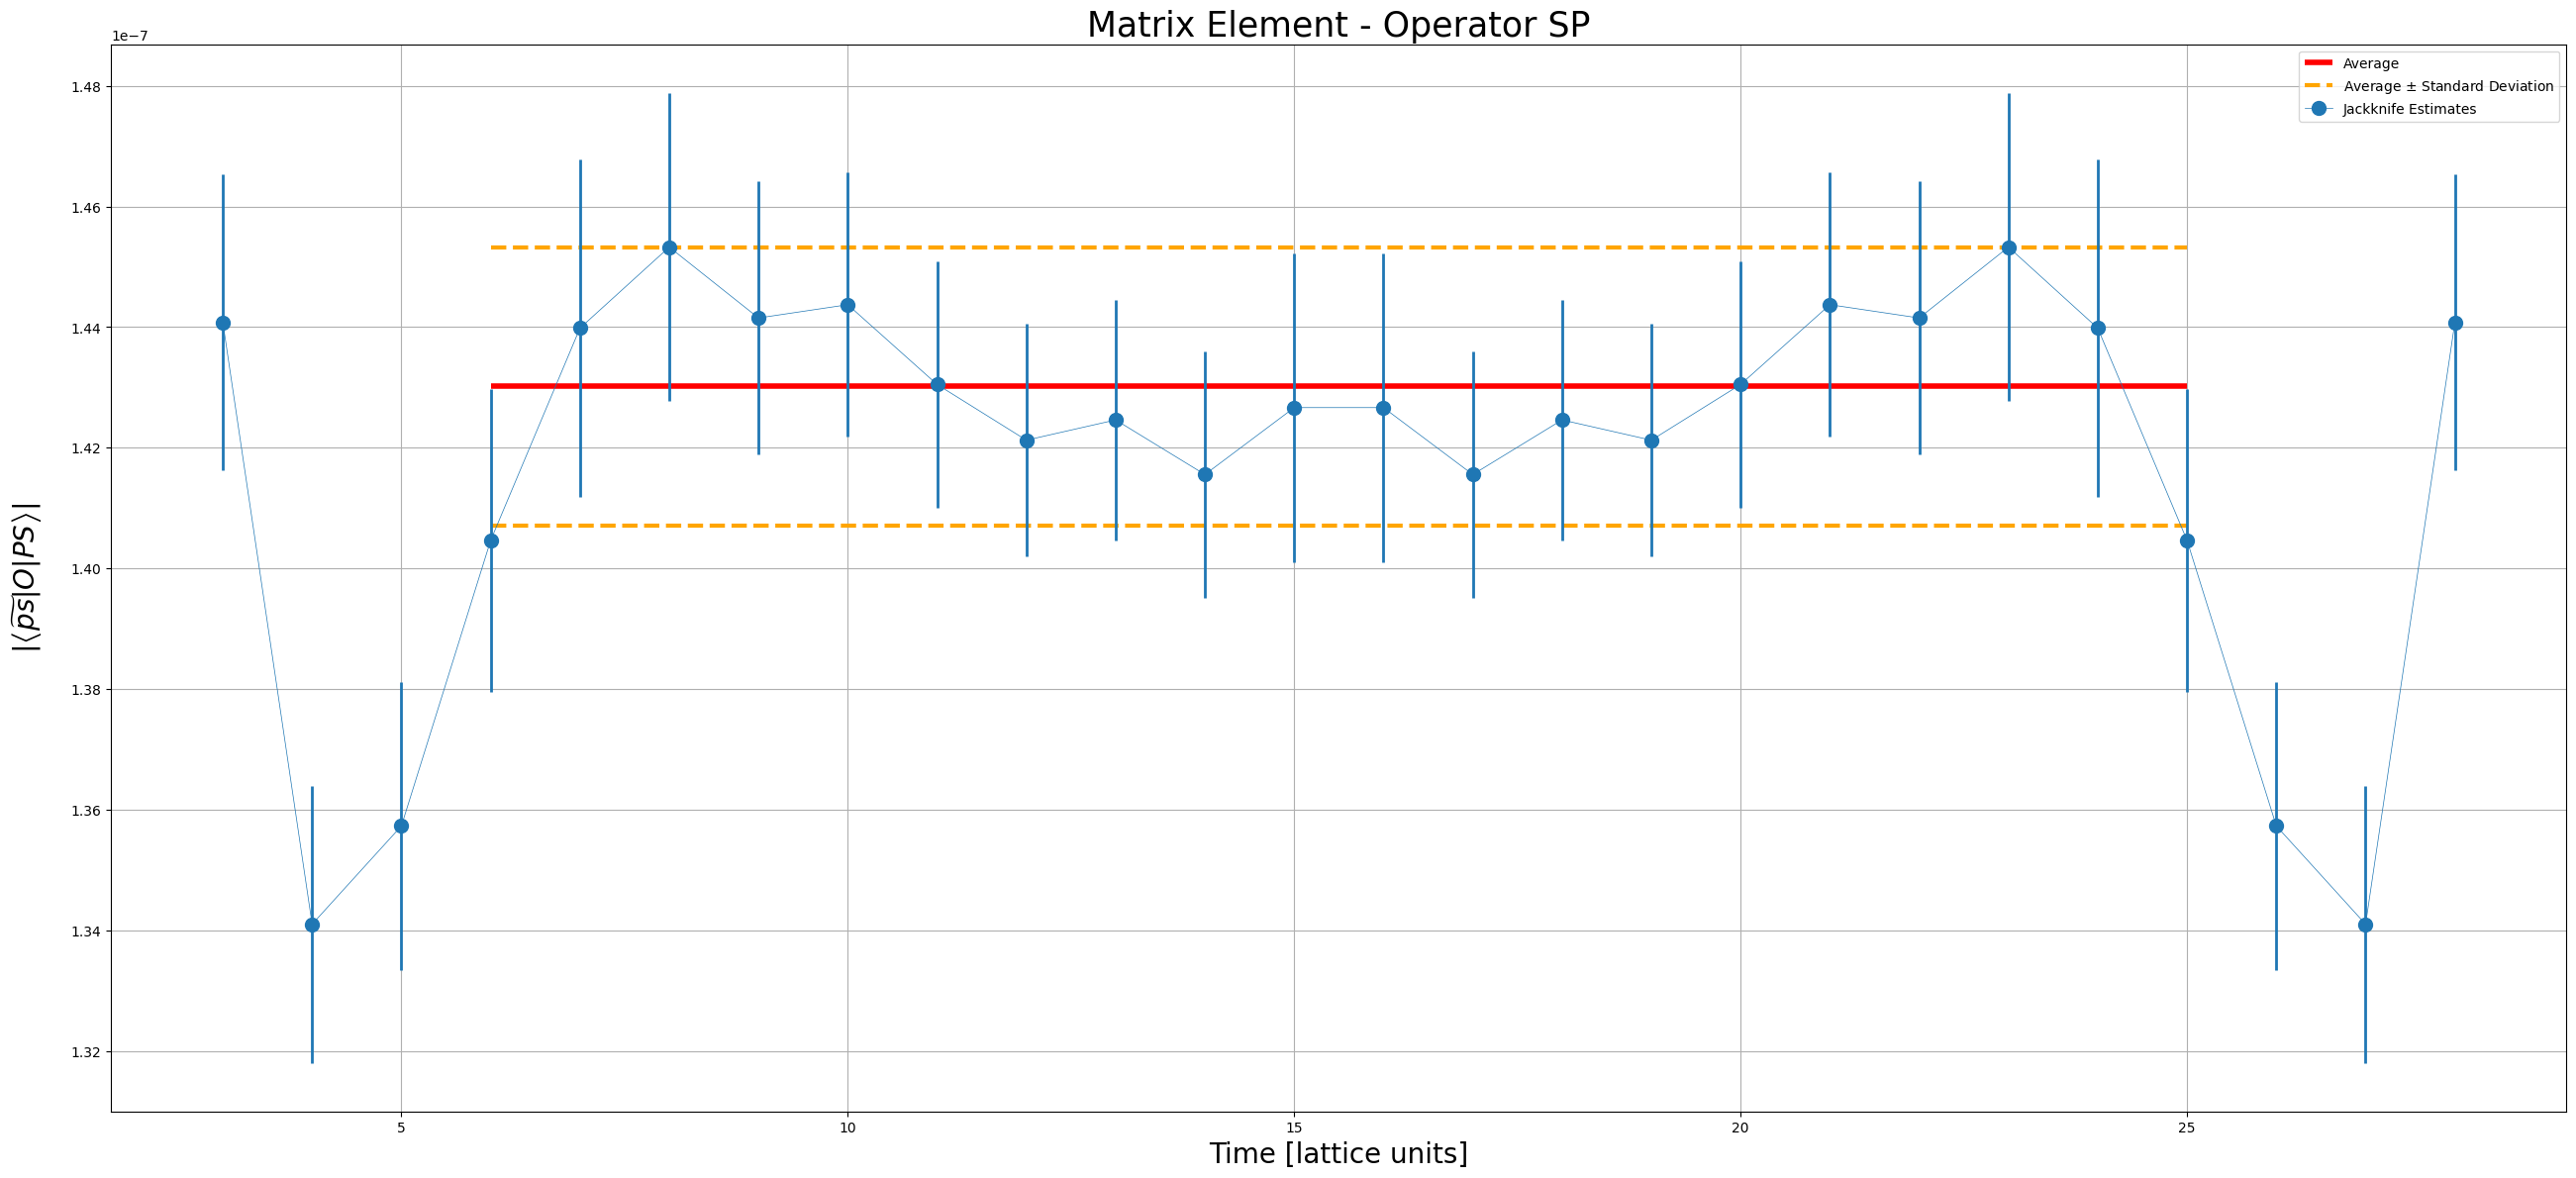

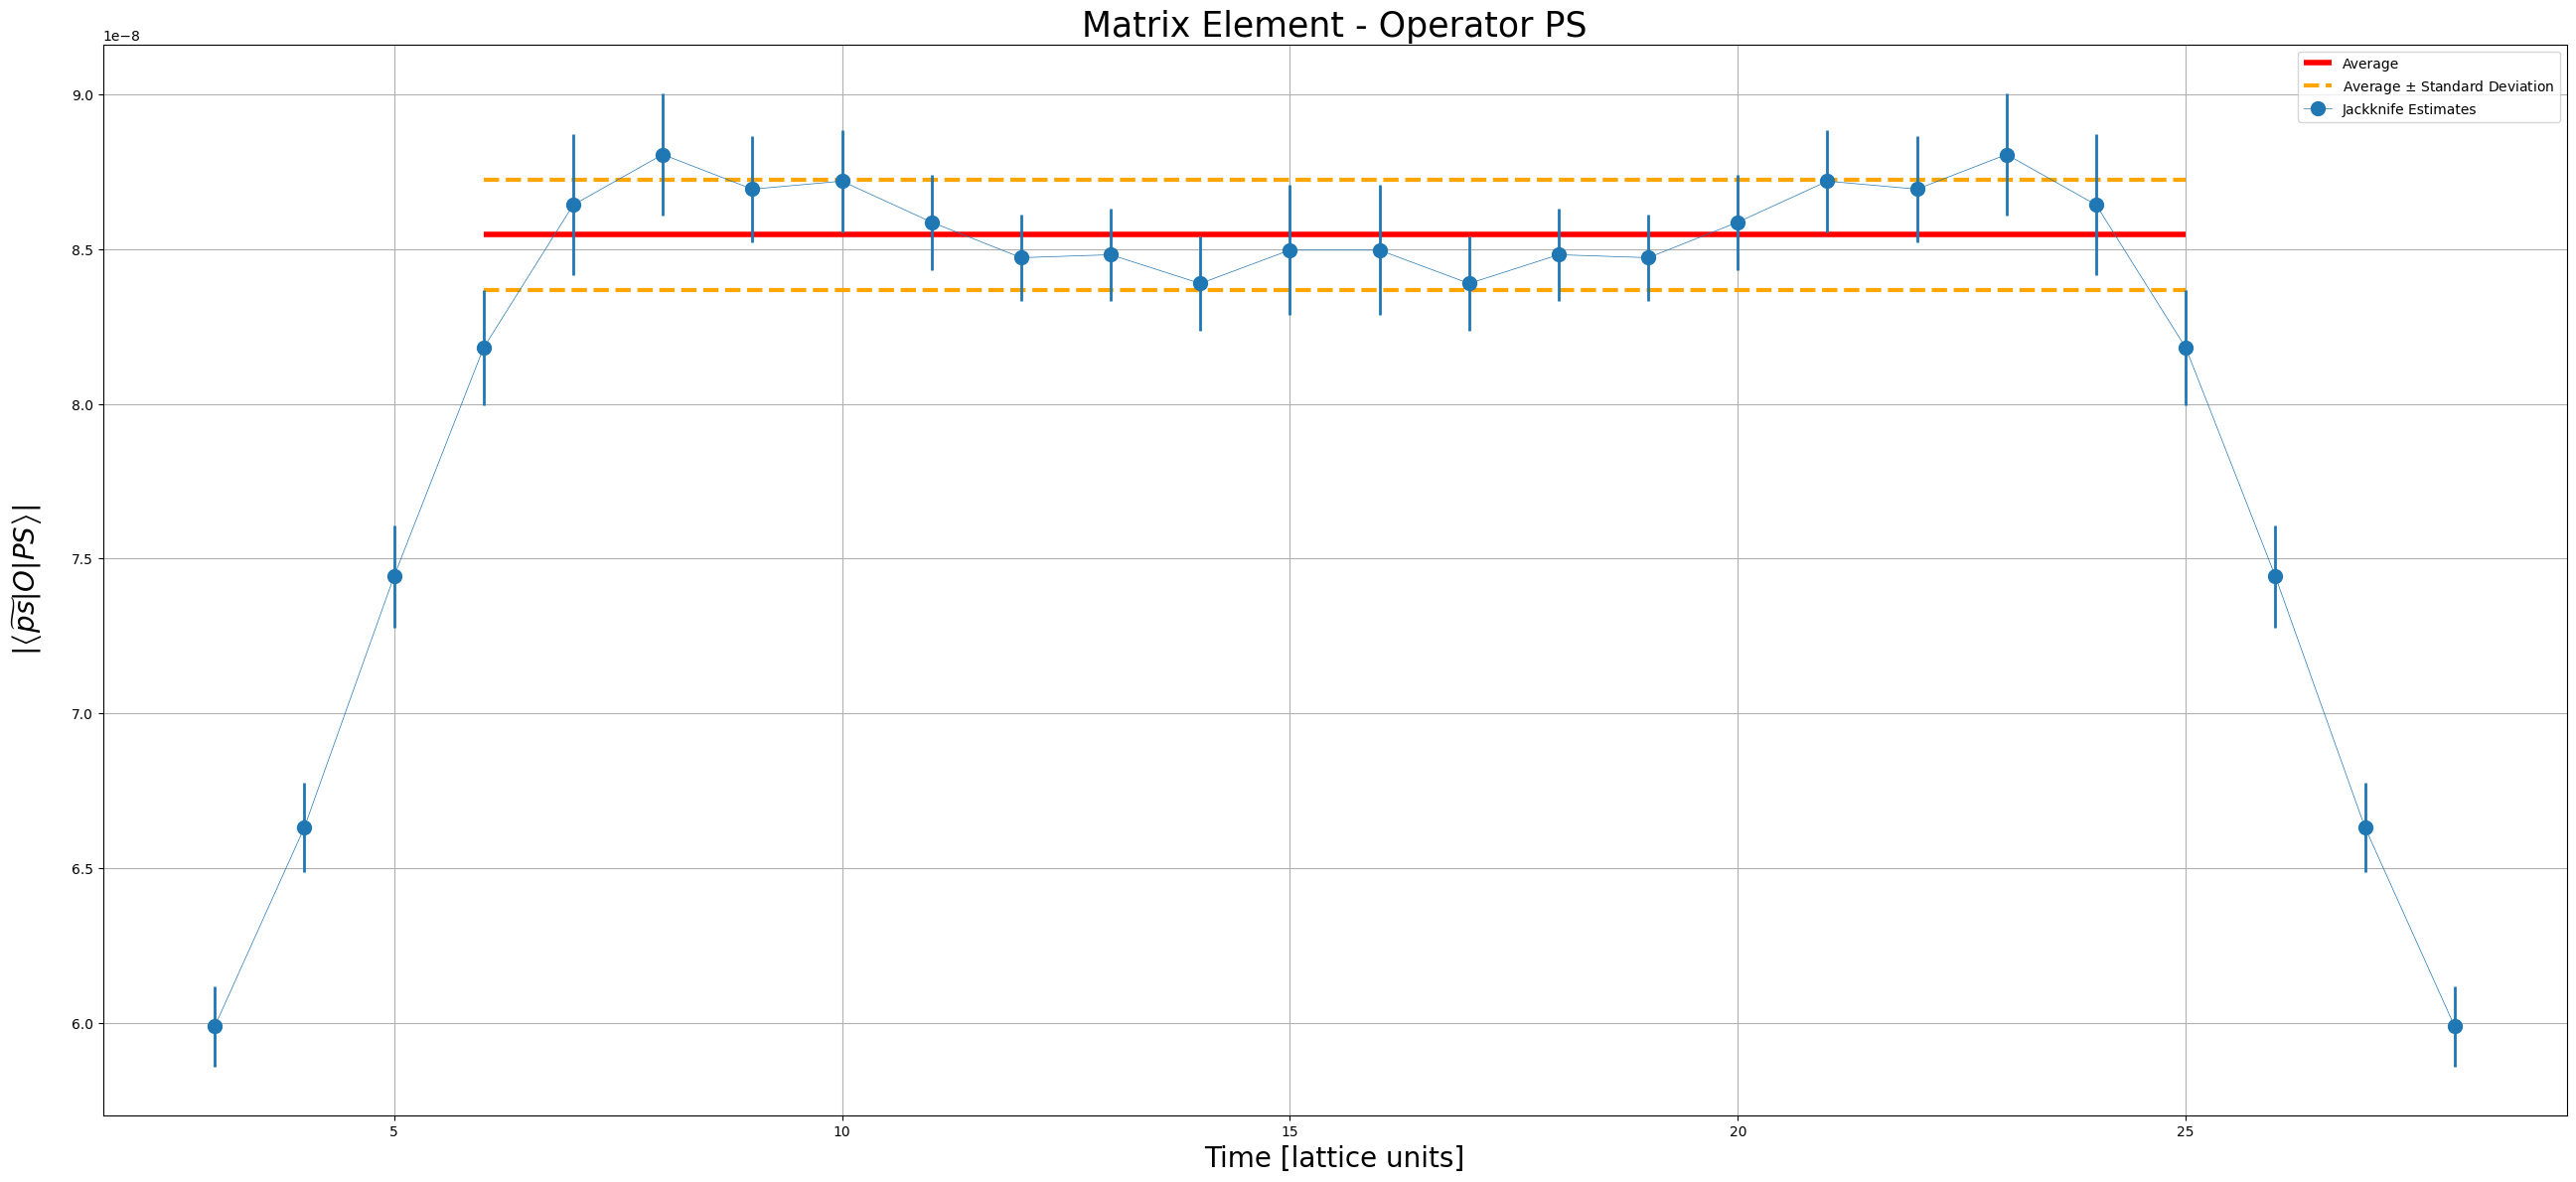

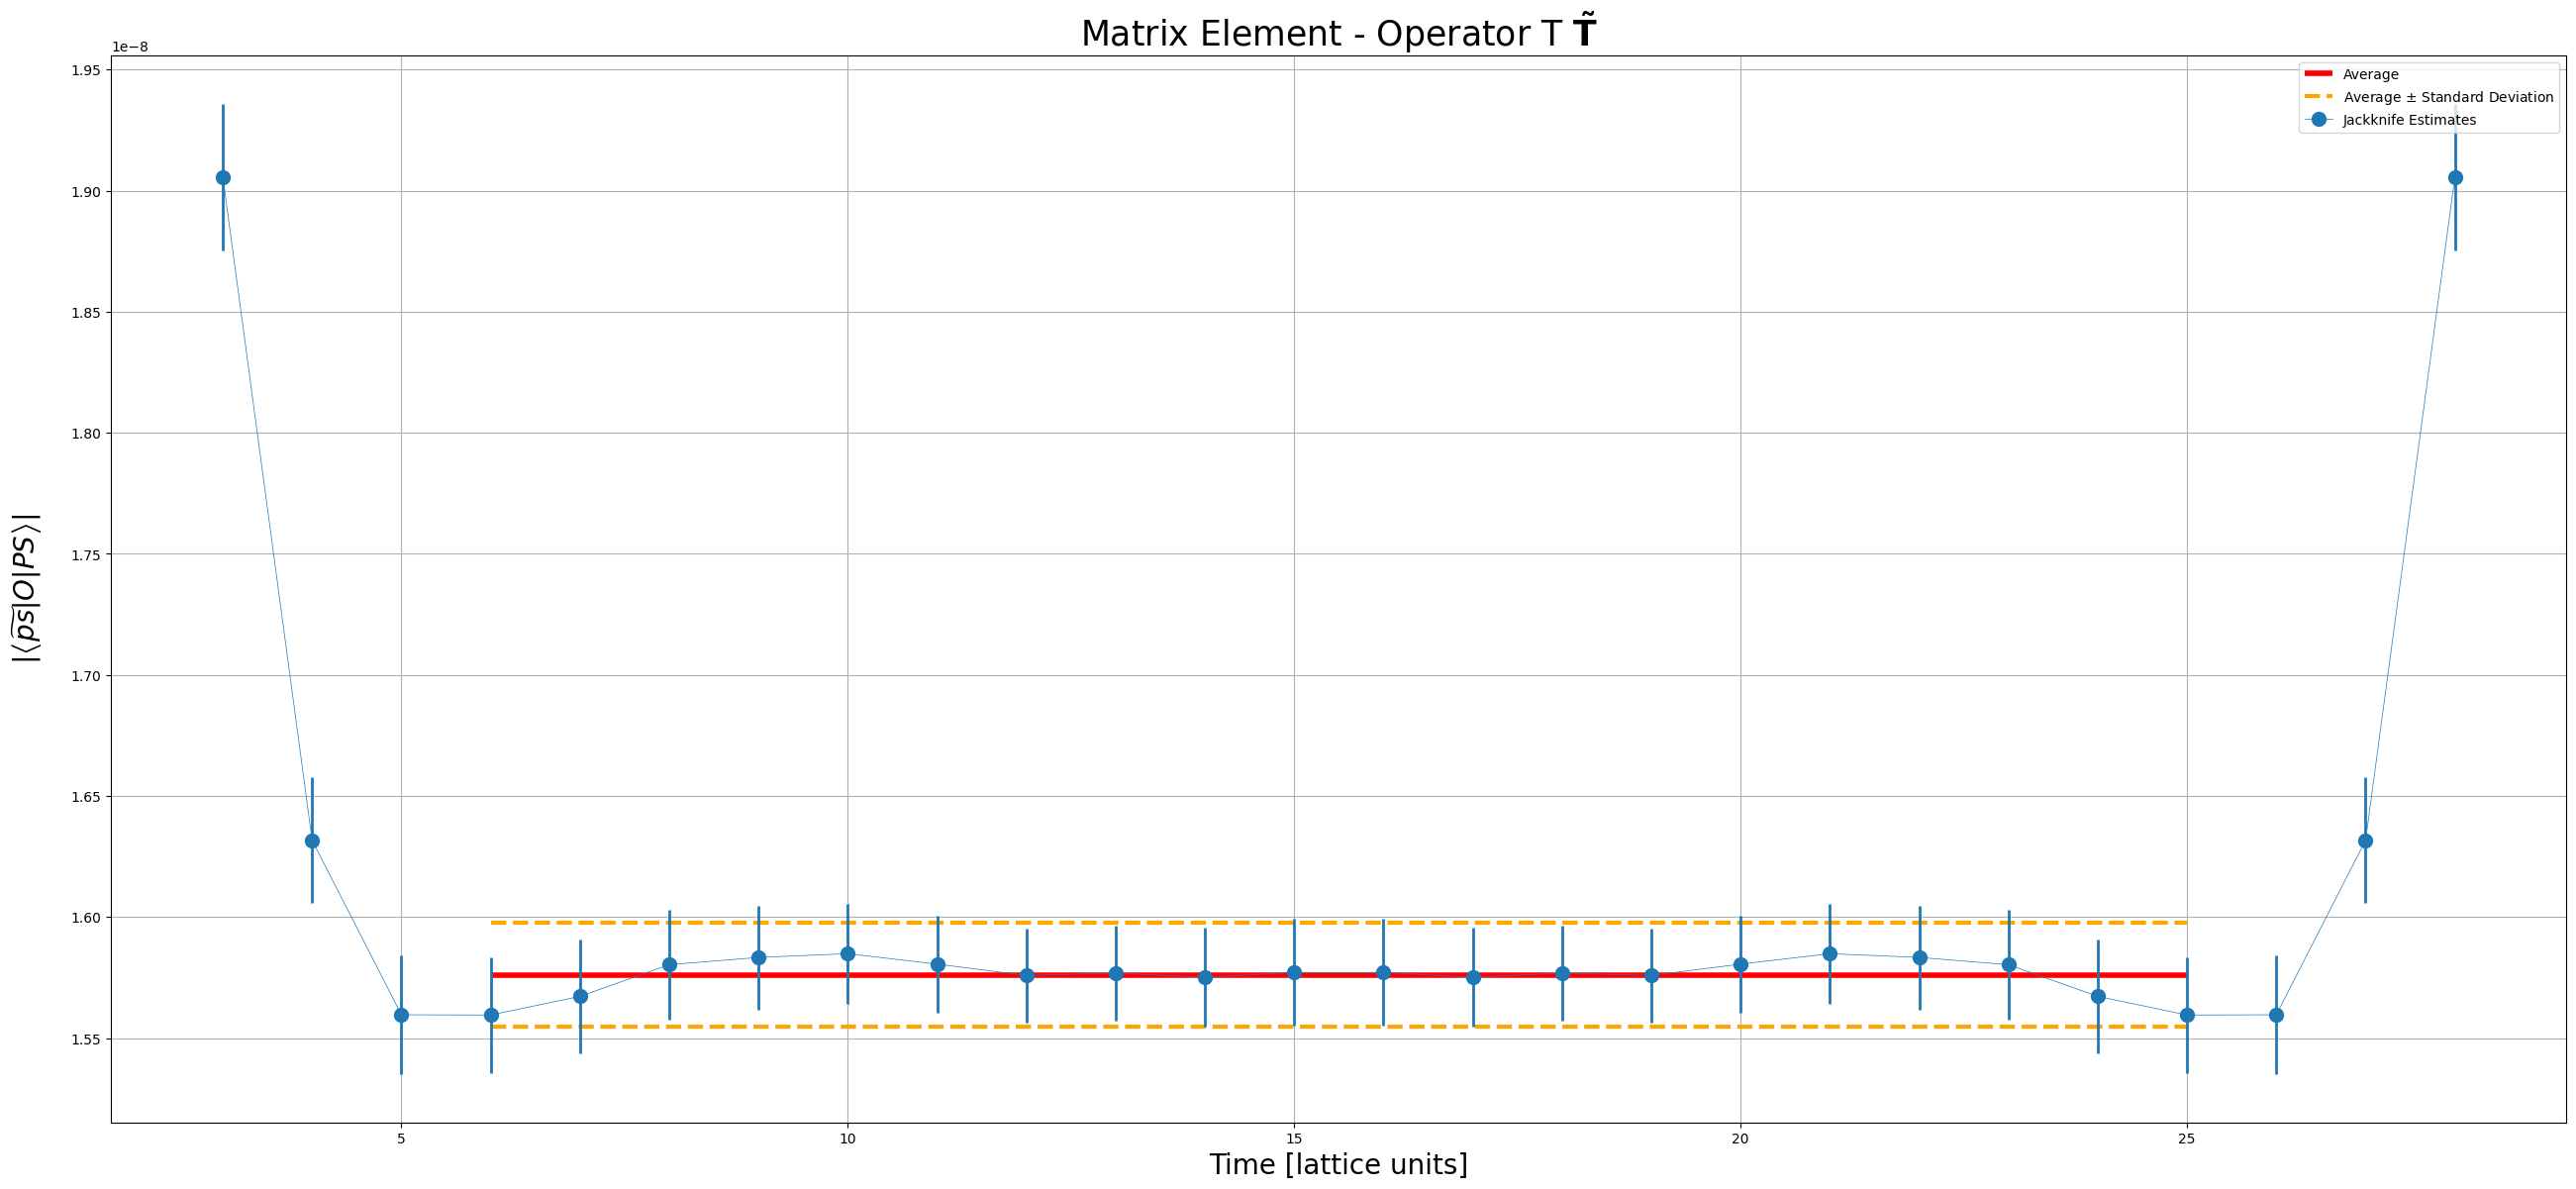

In [33]:
times = np.arange(0,tvals)

cut=chosen_cut

op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']
op_names_txt = ["VA","AV","SP","PS",'TTtilda']

#create figure and axis

for iop in range(noperators):
    _= plt.figure(figsize=(32, 14))

    cut=chosen_cut


    _=plt.hlines(mat_ele_final[iop],cut,tvals-1-cut,color='red',label='Average',linewidth=4)
    _=plt.hlines(mat_ele_final[iop]+mat_ele_final_std[iop],cut,tvals-1-cut,color='orange',linestyle='dashed',linewidth=3)
    _=plt.hlines(mat_ele_final[iop]-mat_ele_final_std[iop],cut,tvals-1-cut,color='orange',linestyle='dashed',label=r'Average $\pm$ Standard Deviation',linewidth=3)

    cut = chosen_cut-3
    
    _=plt.errorbar(times[cut:-cut],estimate_biascorr[iop,cut:-cut],yerr=std[iop,cut:-cut],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2,label='Jackknife Estimates')
    
    plt.grid()
    _=plt.title(f"Matrix Element - Operator {op_names[iop]}",fontsize=25)
    _=plt.ylabel(r'$\left|\left<\widetilde{ps}|O|PS\right>\right|$',rotation=90,labelpad=20,fontsize=20)
    _=plt.xlabel('Time [lattice units]',fontsize=20)

    
    _=plt.legend()
    
    plt.savefig(f'matrix_element_second_analysis/matrix_element_{op_names_txt[iop]}.png')
    #plt.close()